# Problem Statement
Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

## Data Dictionary:

There are two csv files given

- train_1.csv: In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date. The page name contains data in this format:

    * SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
    *having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)


- Exog_Campaign_eng: This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.
    * There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

In [110]:
# !pip install pystan~=2.19
# !pip install fbprophet
# !pip install pmdarima
# !pip install -U -q PyDrive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import ndiffs
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
from pmdarima.arima import auto_arima
from pmdarima.arima import ndiffs
# from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (16, 6)

In [3]:
# Code to read csv file into Colaboratory:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# The shareable link
link = 'https://drive.google.com/file/d/1qQkymAitU6l2pSe702rDUhQpoP8MUZXl/view?usp=share_link' 
id='1qQkymAitU6l2pSe702rDUhQpoP8MUZXl'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_1.csv')  

# https://drive.google.com/drive/folders/1mdgQscjqnCtdg7LGItomyK0abN6lcHBb

In [111]:
# Importing the Pages Information Dataset.
df = pd.read_csv('train_1.csv')
display(df.head(3))

# Setting "Page" variable as Index.
df.set_index('Page',inplace=True)

Page  2015-07-01  2015-07-02  \
0  2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1   2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2    3C_zh.wikipedia.org_all-access_spider         1.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  

[3 rows x 551 columns]

In [112]:
# Since it is a Time-Series dataset, lets put the timestamps as index and the different Pages as columns.
df=df.T
df.index=pd.to_datetime(df.index)
df.head()

Page        2NE1_zh.wikipedia.org_all-access_spider  \
2015-07-01                                     18.0   
2015-07-02                                     11.0   
2015-07-03                                      5.0   
2015-07-04                                     13.0   
2015-07-05                                     14.0   

Page        2PM_zh.wikipedia.org_all-access_spider  \
2015-07-01                                    11.0   
2015-07-02                                    14.0   
2015-07-03                                    15.0   
2015-07-04                                    18.0   
2015-07-05                                    11.0   

Page        3C_zh.wikipedia.org_all-access_spider  \
2015-07-01                                    1.0   
2015-07-02                                    0.0   
2015-07-03                                    1.0   
2015-07-04                                    1.0   
2015-07-05                                    0.0   

Page        4minute_zh.wikipedia.org_all-access_spider  \
2015-07-01                                        35.0   
2015-07-02                                        13.0   
2015-07-03                                        10.0   
2015-07-04                                        94.0   
2015-07-05                                         4.0   

Page        52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider  \
2015-07-01                                                NaN     
2015-07-02                                                NaN     
2015-07-03                                                NaN     
2015-07-04                                                NaN     
2015-07-05                                                NaN     

Page        5566_zh.wikipedia.org_all-access_spider  \
2015-07-01                                     12.0   
2015-07-02                                      7.0   
2015-07-03                                      4.0   
2015-07-04                                      5.0   
2015-07-05                                     20.0   

Page        91Days_zh.wikipedia.org_all-access_spider  \
2015-07-01                                        NaN   
2015-07-02                                        NaN   
2015-07-03                                        NaN   
2015-07-04                                        NaN   
2015-07-05                                        NaN   

Page        A'N'D_zh.wikipedia.org_all-access_spider  \
2015-07-01                                     118.0   
2015-07-02                                      26.0   
2015-07-03                                      30.0   
2015-07-04                                      24.0   
2015-07-05                                      29.0   

Page        AKB48_zh.wikipedia.org_all-access_spider  \
2015-07-01                                       5.0   
2015-07-02                                      23.0   
2015-07-03                                      14.0   
2015-07-04                                      12.0   
2015-07-05                                       9.0   

Page        ASCII_zh.wikipedia.org_all-access_spider  ...  \
2015-07-01                                       6.0  ...   
2015-07-02                                       3.0  ...   
2015-07-03                                       5.0  ...   
2015-07-04                                      12.0  ...   
2015-07-05                                       6.0  ...   

Page        Drake_(músico)_es.wikipedia.org_all-access_spider  \
2015-07-01                                                NaN   
2015-07-02                                                NaN   
2015-07-03                                                NaN   
2015-07-04                                                NaN   
2015-07-05                                                NaN   

Page        Skam_(serie_de_televisión)_es.wikipedia.org_all-access_spider  \
2015-07-01                                                NaN               
2015-07-02   

In [113]:
# Checking the shape of the dataset.
df.shape

# We have 145063 articles for 550 time_periods.

(550, 145063)

count      mean         std  min  25%  50%  75%    max
0  145063.0  42.69132  115.804572  0.0  0.0  0.0  0.0  550.0

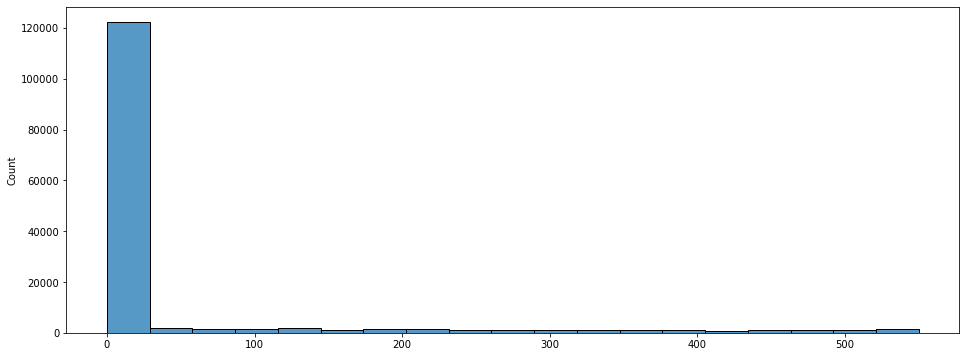

In [114]:
# Lets check for distribution of missing values for the different pages.
display(pd.DataFrame(df.isna().sum().describe()).T)

plt.figure(figsize=(16,6))
_=sns.histplot(df.isna().sum().values)

# Observation: We have some articles for which there are a lot of missing values. Some even have no data at all!

- There could be various reasons why we have Null values in few articles.
- Some articles may have been newly created and thus they would have missing values for past time periods.
- Some articles would not have been in working condition, and thus they would have missing values.
- As per the problem statement, the client wants to know how their ads will perform on pages in different languages. We therefore need language specific articles, which means language specific time-series data. So, we need to merge time series data for several articles as per the language. We can therefore impute the missing values with 0.

In [115]:
# Total Percentage of Missing values in the dataset.
print('Missing Values Percentage:',np.round(df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100,2),'%')

# Imputing the missing values with 0.
df.fillna(0,inplace=True)

Missing Values Percentage: 7.76 %


In [116]:
# Every Page_Name is in the following format - "SPECIFIC NAME_LANGUAGE.wikipedia.org_ACCESS TYPE_ACCESS ORIGIN"
# Lets extract the language from the Page_Name.

page_series=pd.Series(df.columns) #Getting a Series of Page_Names
language_series=page_series.apply(lambda x : x[x.find('wikipedia')-3:x.find('wikipedia')-1]) #Extracting Language

# Lets look at the various available languages.
display(language_series.value_counts())

# We can drop the Pages which have languages: "02" and ":P"
new_page_series=page_series.iloc[language_series[~(language_series.isin([":P","02"]))].index]
df=df.loc[:,new_page_series]

en    37662
ja    20431
de    18547
fr    17802
zh    17229
ru    15022
es    14069
id     4297
02        3
:P        1
Name: Page, dtype: int64

#### Language Encodings
* 'zh' - "Chinese"
* 'fr' - "French"
* 'en' - "English"
* 'id' - "Indonesian"
* 'ru' - "Russian"
* 'de' - "German"
* 'ja' - "Japanese"
* 'es' - "Spanish"

In [117]:
# Creating a Dictionary to segregate the names of pages on the basis of language.
page_series=pd.Series(df.columns) #Getting a Series of Page_Names
language_series=page_series.apply(lambda x : x[x.find('wikipedia')-3:x.find('wikipedia')-1]) #Extracting Language

language_codes=['zh', 'fr', 'en', 'id', 'ru', 'de', 'ja', 'es']
language_dict={}
for code in language_codes: # Storing the page names in a dictionary with key as their respective language
    language_dict[code]=page_series.iloc[language_series[language_series==code].index].tolist()

In [118]:
# Merging the pages which have similar languages.

chinese=df.loc[:,language_dict['zh']].sum(axis=1)
french=df.loc[:,language_dict['fr']].sum(axis=1)
english=df.loc[:,language_dict['en']].sum(axis=1)
indonesian=df.loc[:,language_dict['id']].sum(axis=1)
russian=df.loc[:,language_dict['ru']].sum(axis=1)
german=df.loc[:,language_dict['de']].sum(axis=1)
japanese=df.loc[:,language_dict['ja']].sum(axis=1)
spanish=df.loc[:,language_dict['es']].sum(axis=1)

# EDA

## 1) English

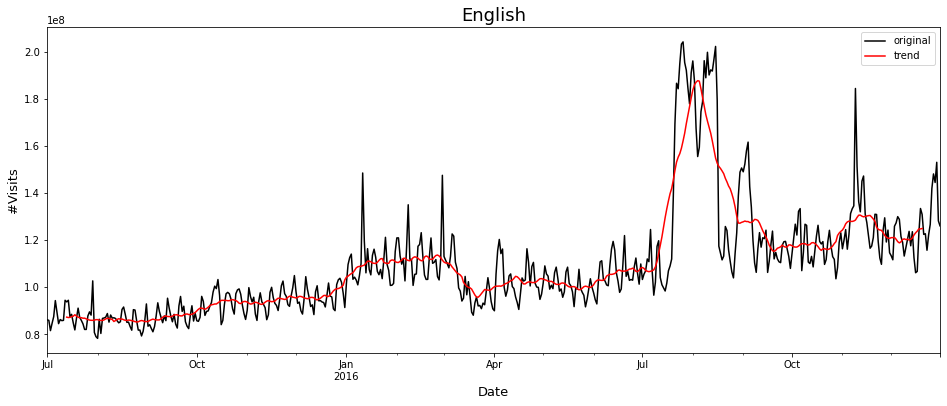

In [119]:
# PLotting the Time-Series.

plt.figure(figsize=(16,6))
english.plot(label='original',color='black')
english.rolling(24, center=True).mean().plot(label='trend',color='r')
plt.title("English",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)
plt.legend()
plt.show()

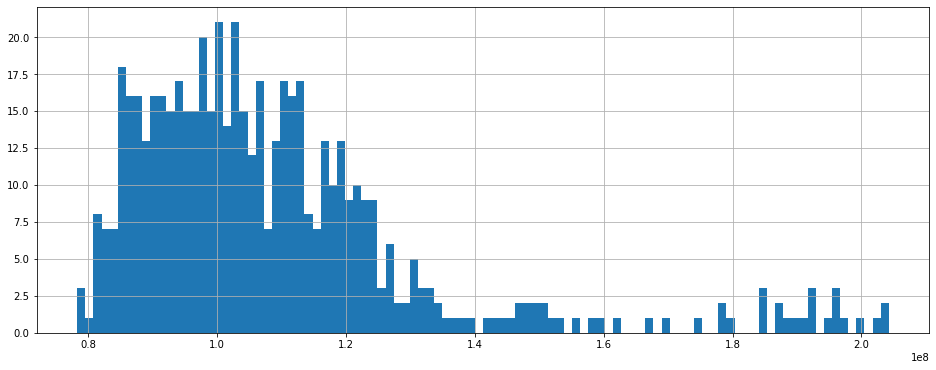

In [120]:
# Checking for anomalies.
plt.figure(figsize=(16,6))
_=english.hist(bins=100)

Observation: We can observe that there are certain large and small present anomalies in the chinese dataset.

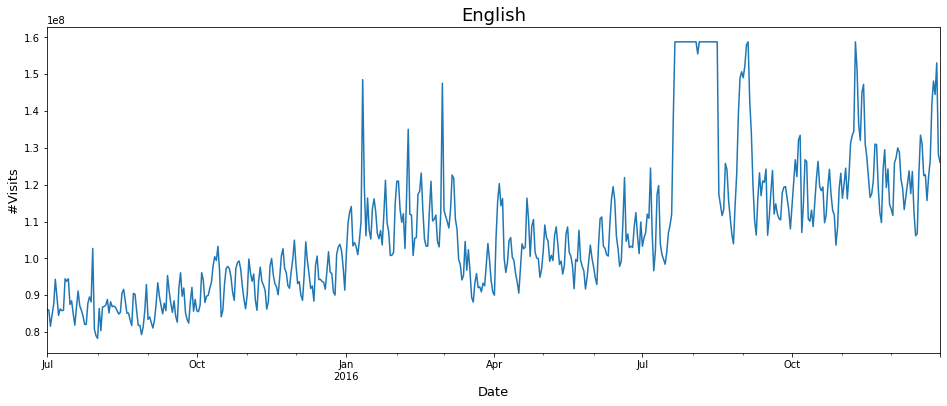

In [121]:
# Removing anomalies by clipping the top 5 percent data.
plt.figure(figsize=(16,6))
_=english.clip(lower=english.quantile(0),upper=english.quantile(0.95)).plot()
plt.title("English",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)

english=english.clip(lower=english.quantile(0),upper=english.quantile(0.95))# Re-assigning the new dataset after clipping

### Decomposition of Time Series into different Components.

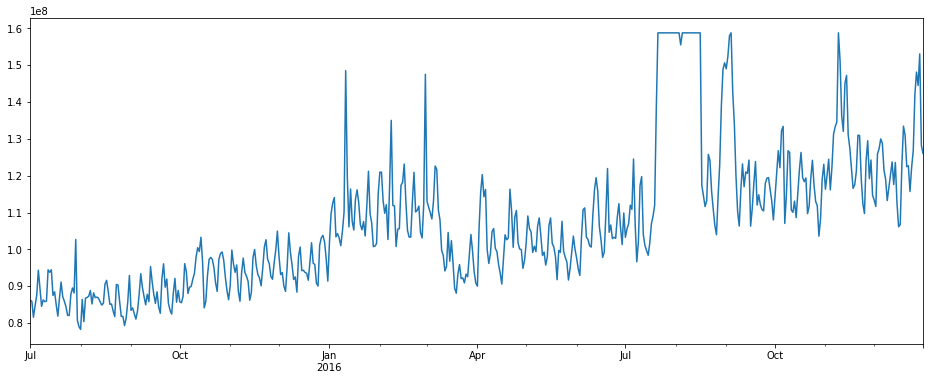

In [122]:
# Original Time Series Data
_=english.plot()

model = sm.tsa.seasonal_decompose(english,model='additive')

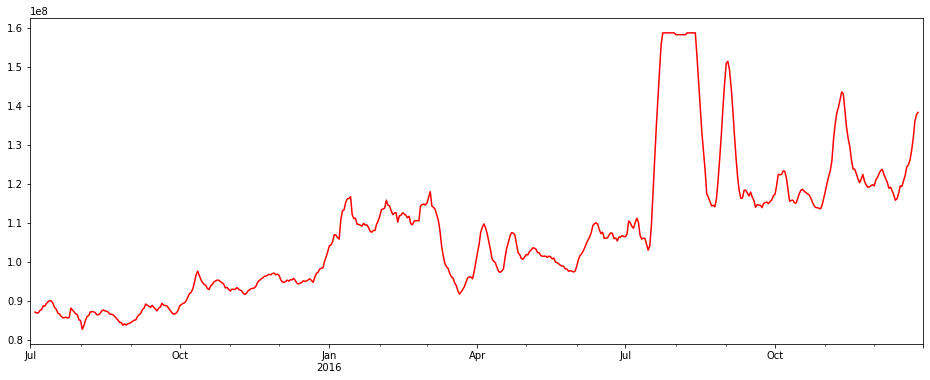

In [123]:
# Geeting the trend component of the time-series.
_=model.trend.plot(figsize=(16, 6),c='red')

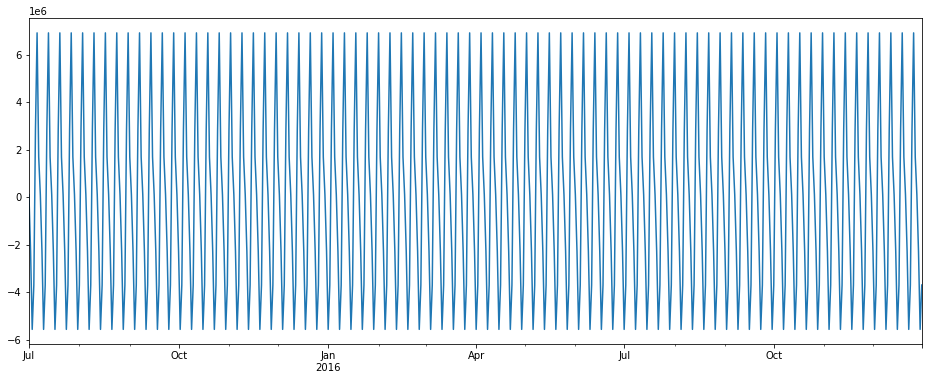

In [124]:
# Geeting the seasonal component of the time-series.
_=model.seasonal.plot(figsize=(16, 6))

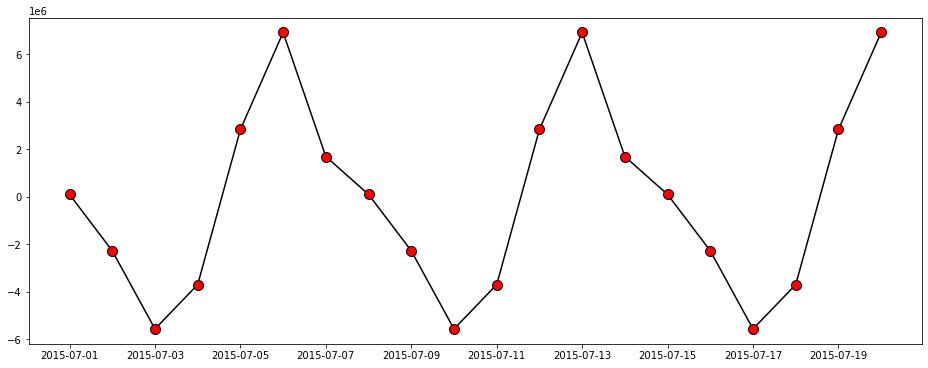

In [125]:
# Geeting the seasonal component of the time-series for a shorter time period.
_=plt.plot(model.seasonal[:20],color='black',marker='o',markerfacecolor='red',markersize=10)

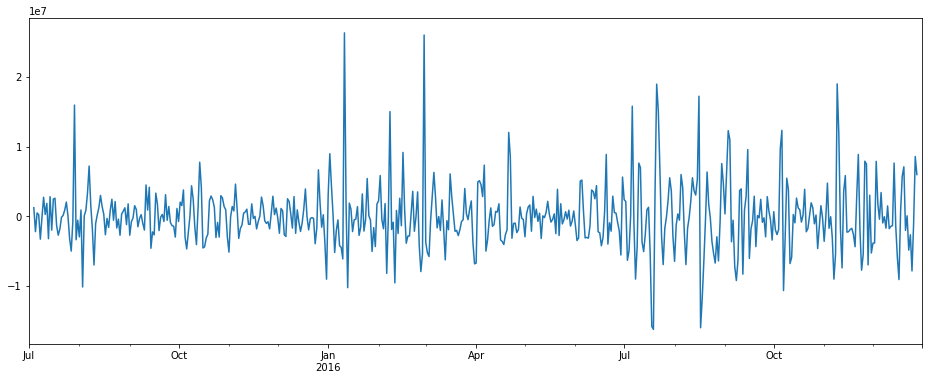

In [126]:
# Geeting the residual component of the time-series.
_=model.resid.plot(figsize=(16, 6))

Observation : 
* We can see an upward trend in the dataset.
* There is weekly seasonality in the data.
- The mean of the residuals is close to 0, but there are some big residuals at some places.

## 2) Chinese

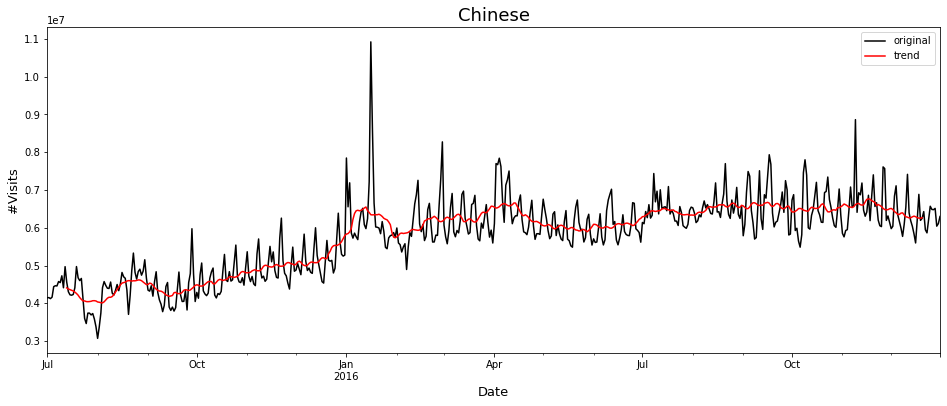

In [43]:
# PLotting the Time-Series.

plt.figure(figsize=(16,6))
chinese.plot(label='original',color='black')
chinese.rolling(24, center=True).mean().plot(label='trend',color='r')
plt.title("Chinese",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)
plt.legend()
plt.show()

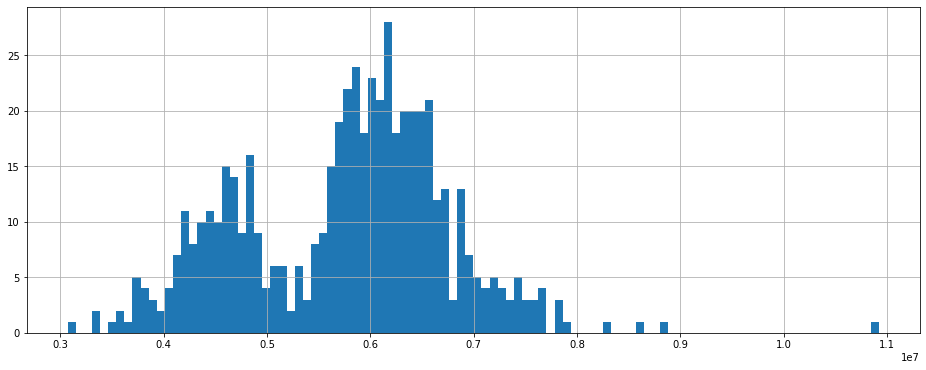

In [44]:
# Checking for anomalies.
plt.figure(figsize=(16,6))
_=chinese.hist(bins=100)

Observation: We can observe that there are certain large and small present anomalies in the chinese dataset.

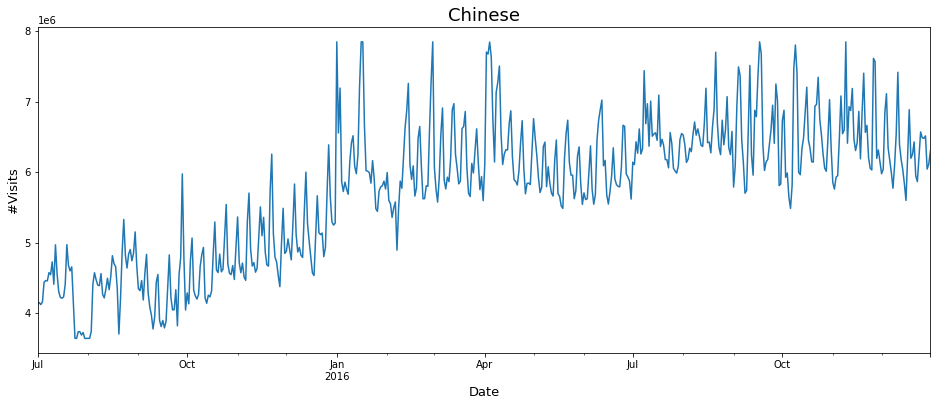

In [45]:
# Removing anomalies by clipping the top and bottom 1 percent data.
plt.figure(figsize=(16,6))
_=chinese.clip(lower=chinese.quantile(0.01),upper=chinese.quantile(0.99)).plot()
plt.title("Chinese",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)

chinese=chinese.clip(lower=chinese.quantile(0.01),upper=chinese.quantile(0.99))# Re-assigning the new dataset after clipping

### Decomposition of Time Series into different Components.

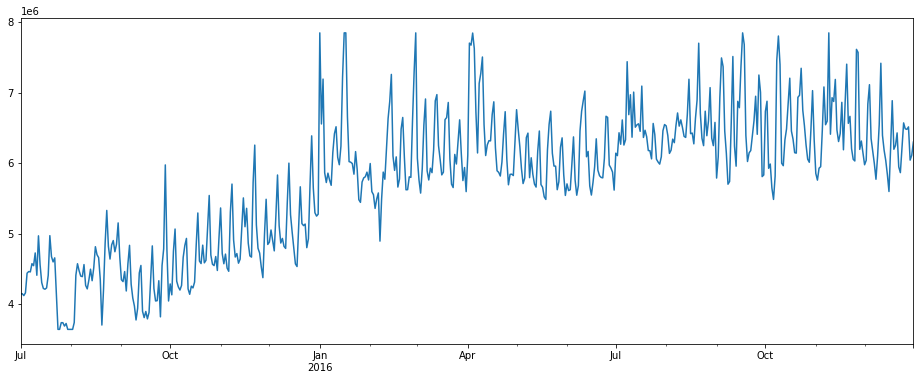

In [46]:
# Original Time Series Data
_=chinese.plot()

model = sm.tsa.seasonal_decompose(chinese,model='additive')

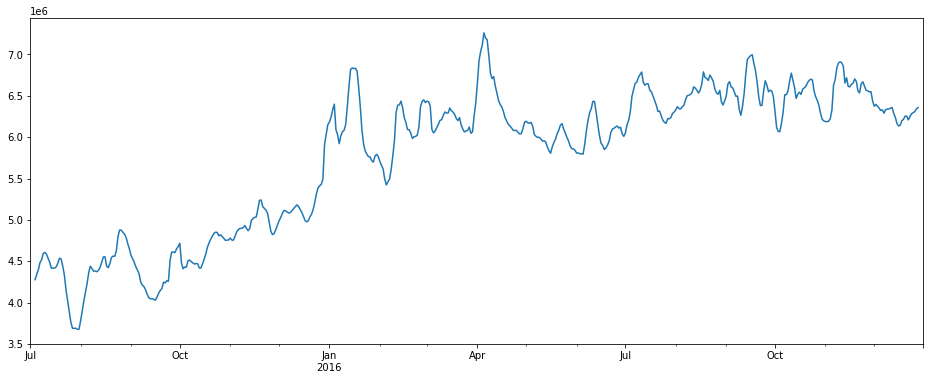

In [47]:
# Geeting the trend component of the time-series.
_=model.trend.plot(figsize=(16, 6))

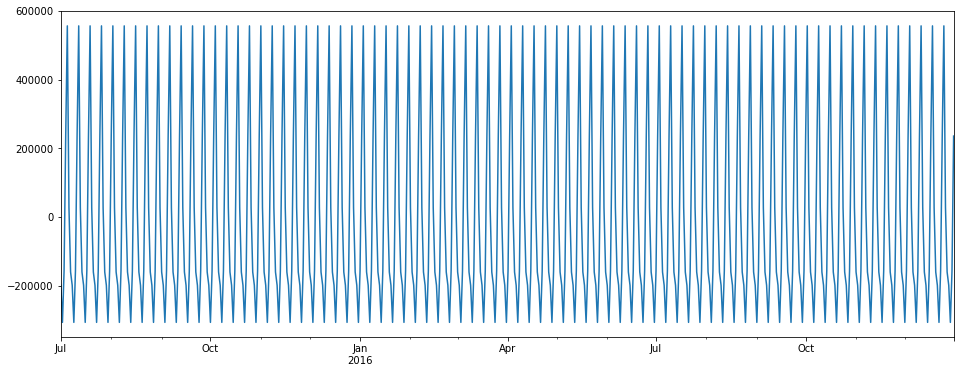

In [48]:
# Geeting the seasonal component of the time-series.
_=model.seasonal.plot(figsize=(16, 6))

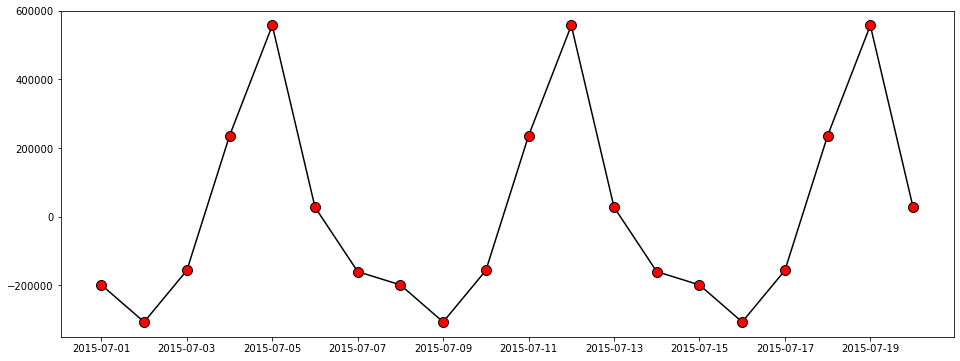

In [49]:
# Geeting the seasonal component of the time-series for a shorter time period.
_=plt.plot(model.seasonal[:20],color='black',marker='o',markerfacecolor='red',markersize=10)

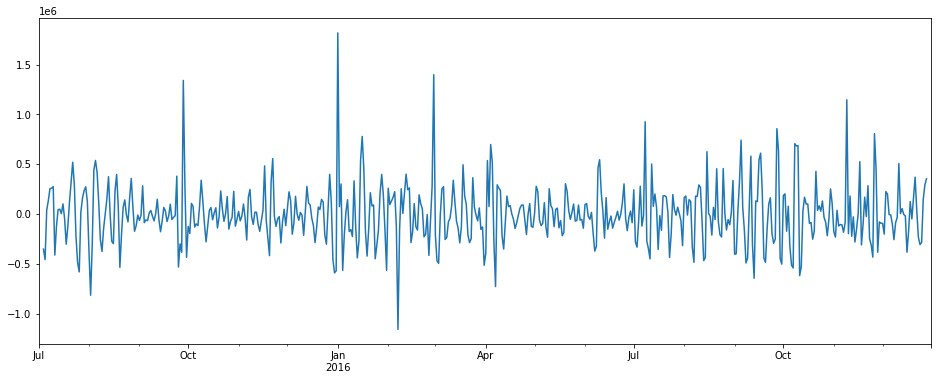

In [50]:
# Geeting the residual component of the time-series.
_=model.resid.plot(figsize=(16, 6))

Observation : 
* We can see an upward trend in the dataset.
* There is weekly seasonality in the data.
- The mean of the residuals is close to 0, but there are some big residuals at some places.

## 3) French

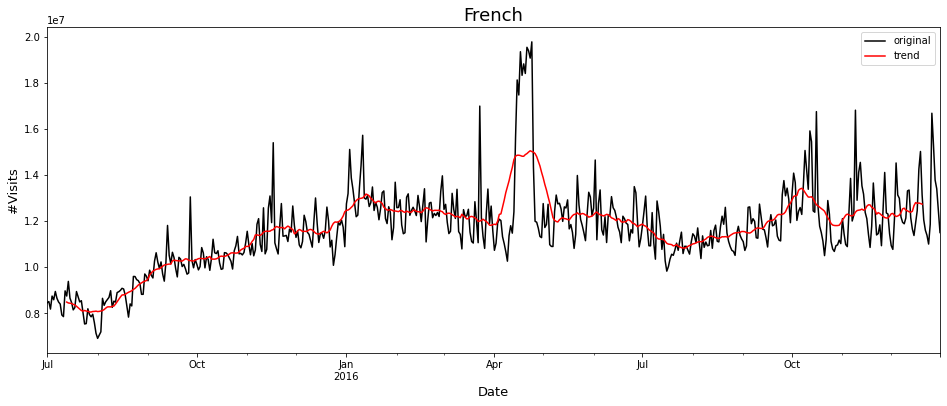

In [51]:
# PLotting the Time-Series.

plt.figure(figsize=(16,6))
french.plot(label='original',color='black')
french.rolling(24, center=True).mean().plot(label='trend',color='r')
plt.title("French",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)
plt.legend()
plt.show()

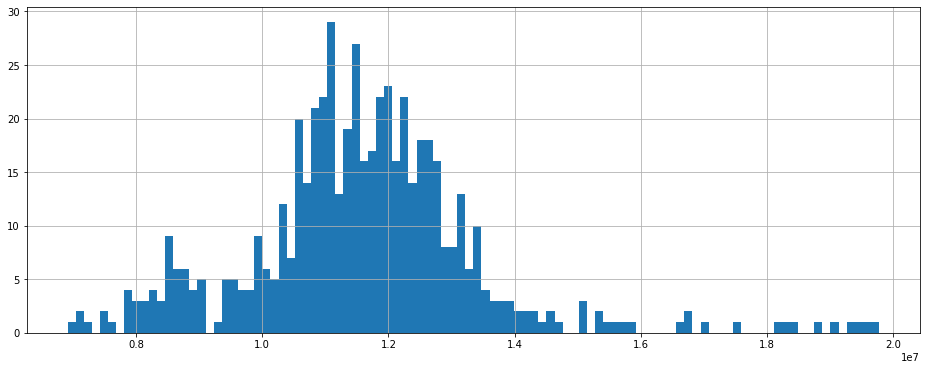

In [52]:
# Checking for anomalies.
plt.figure(figsize=(16,6))
_=french.hist(bins=100)

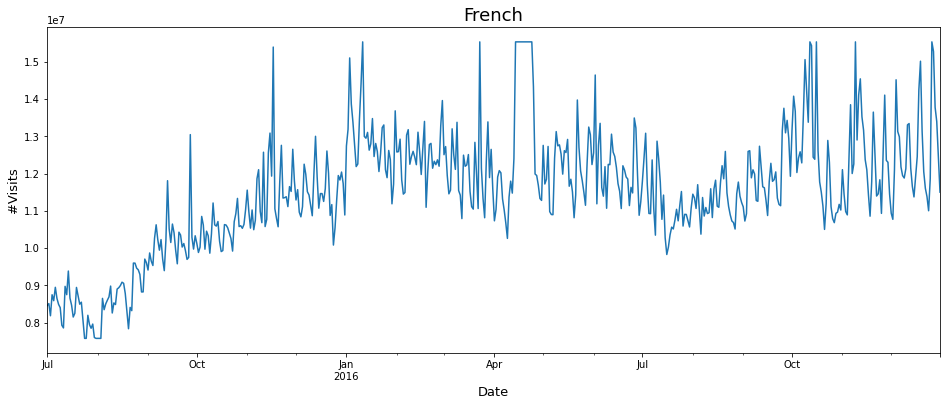

In [53]:
# Removing anomalies by clipping the top 3 percent and bottom 1 percent data.
plt.figure(figsize=(16,6))
_=french.clip(lower=french.quantile(0.01),upper=french.quantile(0.97)).plot()
plt.title("French",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)

french=french.clip(lower=french.quantile(0.01),upper=french.quantile(0.97)) # Re-assigning the new dataset after clipping

### Decomposition of Time Series into different Components.

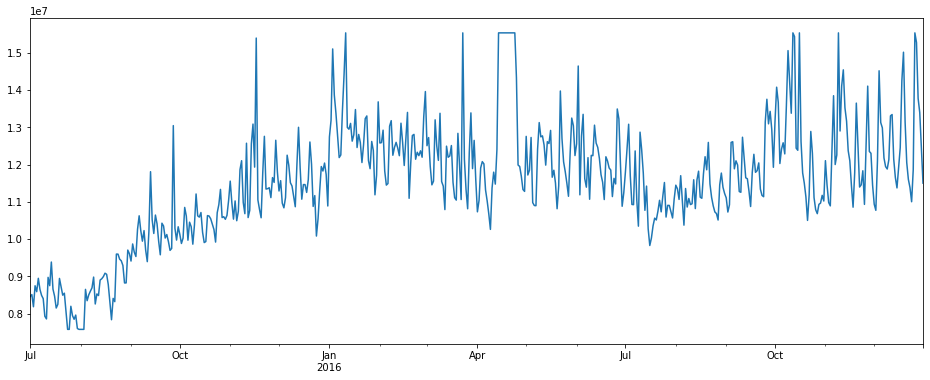

In [54]:
# Original Time Series Data
_=french.plot()

model = sm.tsa.seasonal_decompose(french,model='additive')

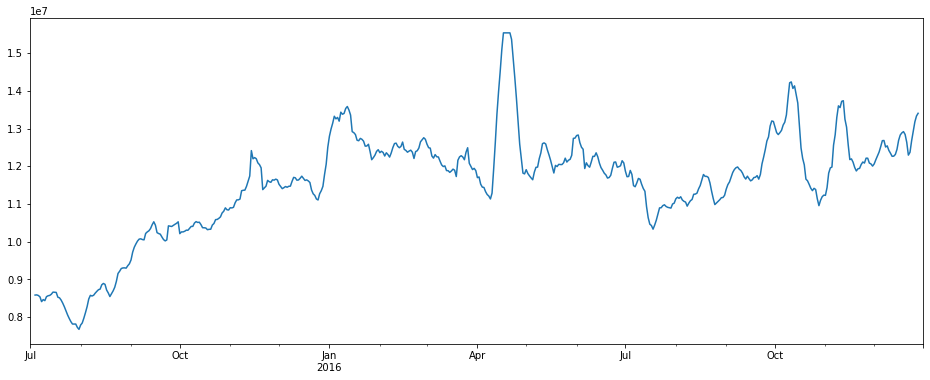

In [55]:
# Geeting the trend component of the time-series.
_=model.trend.plot(figsize=(16, 6))

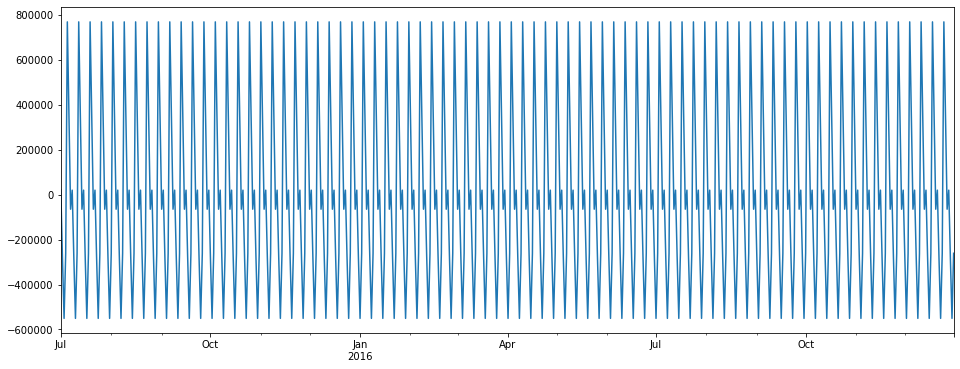

In [56]:
# Geeting the seasonal component of the time-series.
_=model.seasonal.plot(figsize=(16, 6))

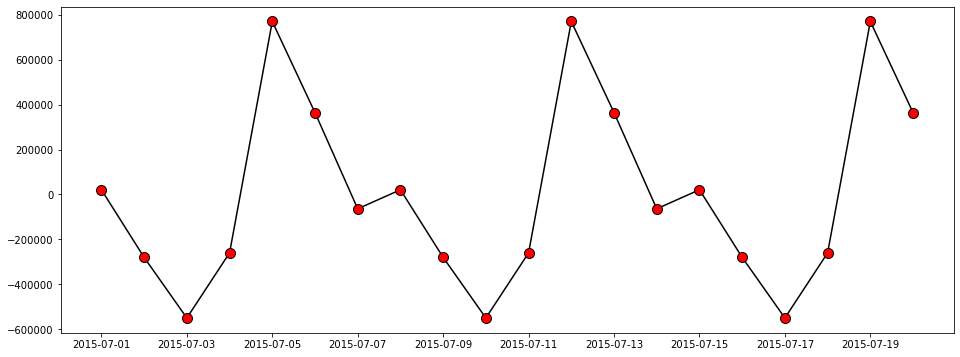

In [57]:
# Geeting the seasonal component of the time-series for a shorter time period.
_=plt.plot(model.seasonal[:20],color='black',marker='o',markerfacecolor='red',markersize=10)

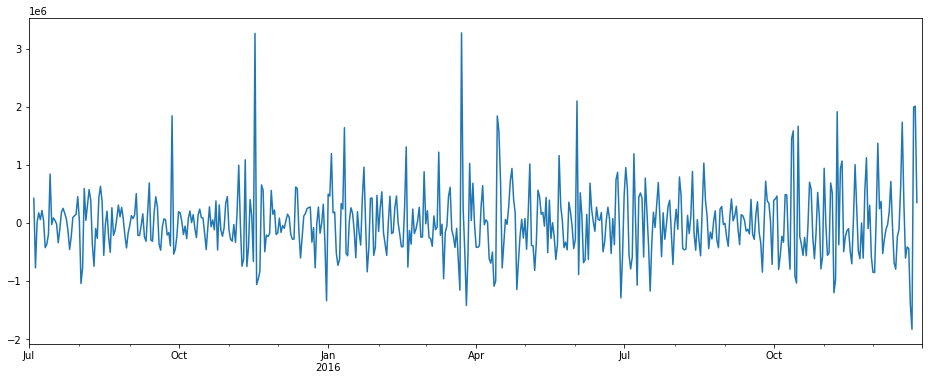

In [58]:
# Geeting the residual component of the time-series.
_=model.resid.plot(figsize=(16, 6))

Observation : 
* We can see an upward trend in the dataset.
* There is weekly seasonality in the data.
- The mean of the residuals is close to 0, but there are some big residuals at some places.

## 4) Indonesian

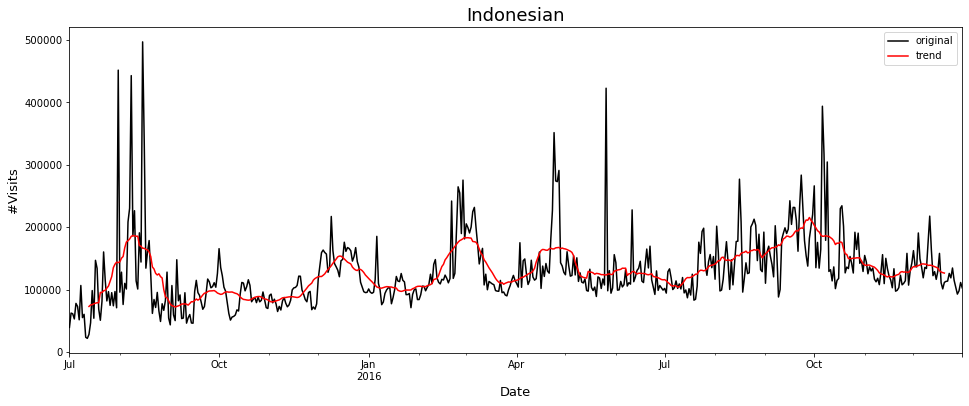

In [59]:
# PLotting the Time-Series.

plt.figure(figsize=(16,6))
indonesian.plot(label='original',color='black')
indonesian.rolling(24, center=True).mean().plot(label='trend',color='r')
plt.title("Indonesian",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)
plt.legend()
plt.show()

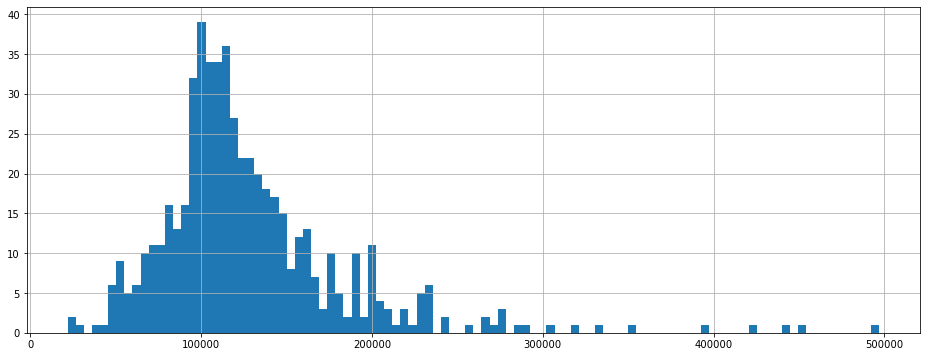

In [60]:
# Checking for anomalies.
plt.figure(figsize=(16,6))
_=indonesian.hist(bins=100)

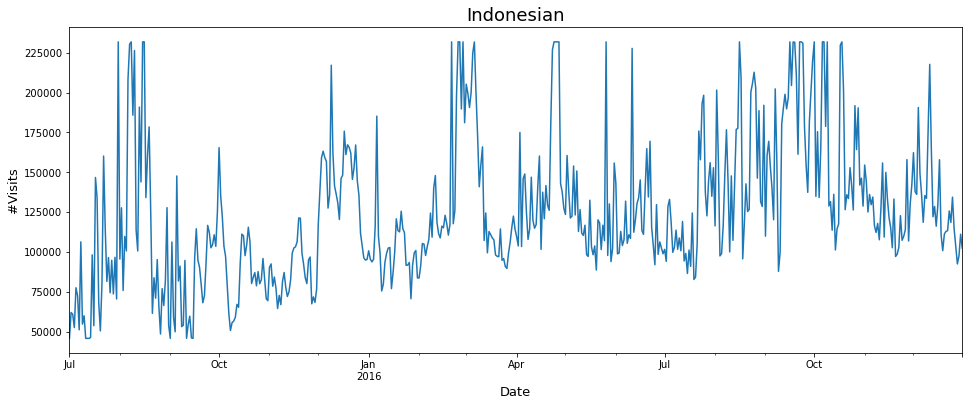

In [61]:
# Removing anomalies by clipping the top 4 percent and bottom 1 percent data.
plt.figure(figsize=(16,6))
_=indonesian.clip(lower=indonesian.quantile(0.01),upper=indonesian.quantile(0.96)).plot()
plt.title("Indonesian",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)

# Re-assigning the new dataset after clipping.
indonesian=indonesian.clip(lower=indonesian.quantile(0.01),upper=indonesian.quantile(0.96))

### Decomposition of Time Series into different Components.

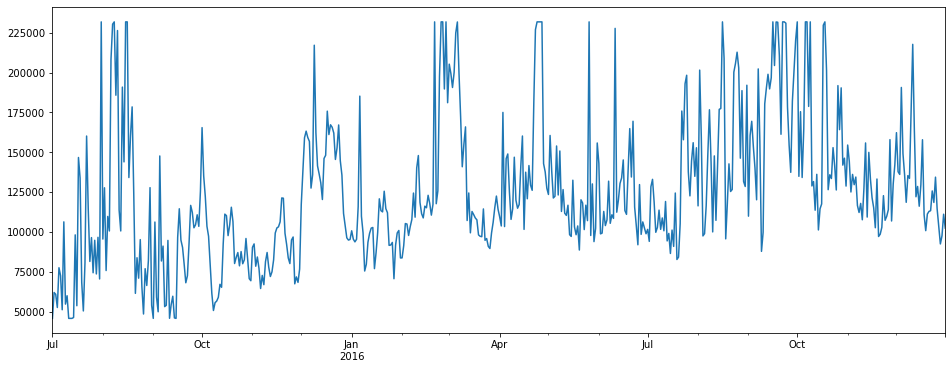

In [62]:
# Original Time Series Data
_=indonesian.plot()

model = sm.tsa.seasonal_decompose(indonesian,model='additive')

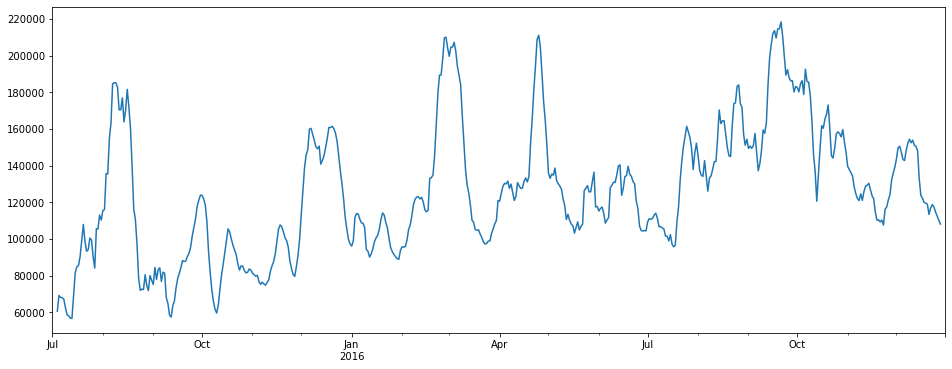

In [63]:
# Geeting the trend component of the time-series.
_=model.trend.plot(figsize=(16, 6))

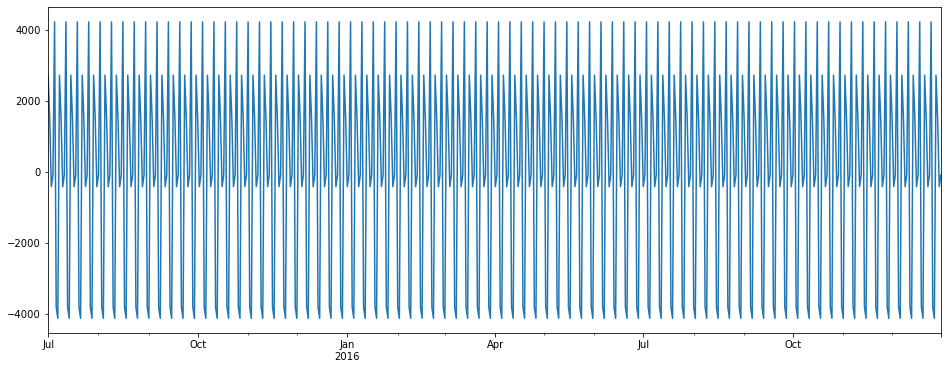

In [64]:
# Geeting the seasonal component of the time-series.
_=model.seasonal.plot(figsize=(16, 6))

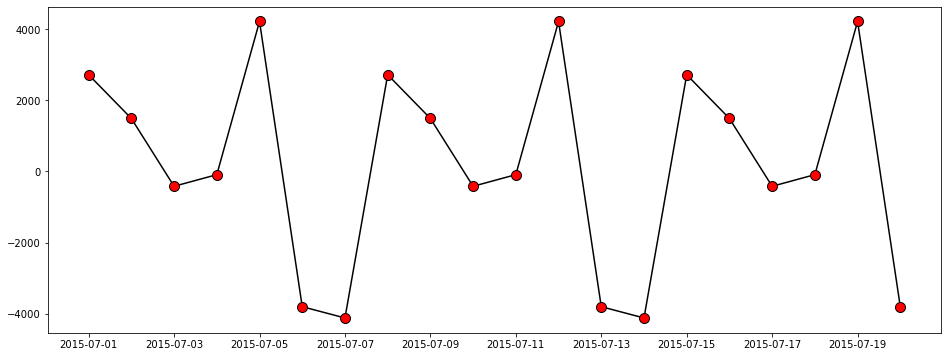

In [65]:
# Geeting the seasonal component of the time-series for a shorter time period.
_=plt.plot(model.seasonal[:20],color='black',marker='o',markerfacecolor='red',markersize=10)

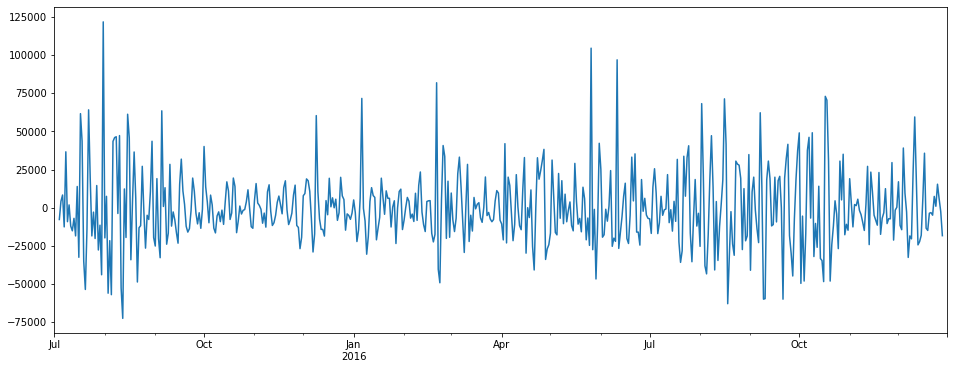

In [66]:
# Geeting the residual component of the time-series.
_=model.resid.plot(figsize=(16, 6))

Observation : 
* We can see an upward trend in the dataset.
* There is weekly seasonality in the data.
- The mean of the residuals is close to 0, but there are some big residuals at some places.

## 5) Russian

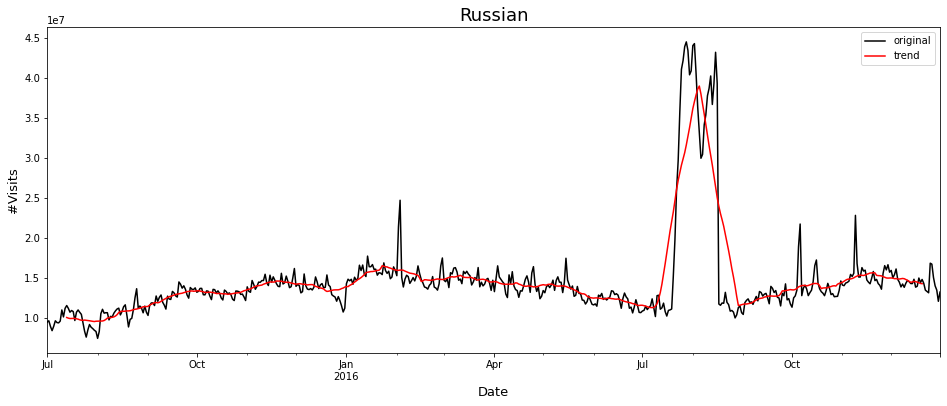

In [67]:
# PLotting the Time-Series.

plt.figure(figsize=(16,6))
russian.plot(label='original',color='black')
russian.rolling(24, center=True).mean().plot(label='trend',color='r')
plt.title("Russian",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)
plt.legend()
plt.show()

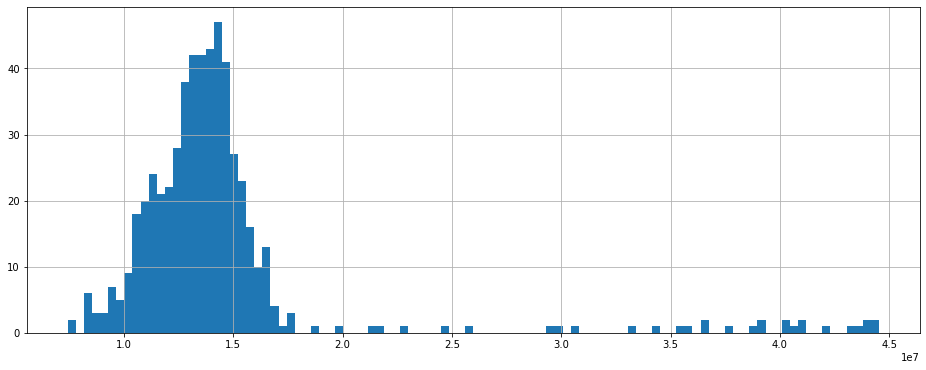

In [68]:
# Checking for anomalies.
plt.figure(figsize=(16,6))
_=russian.hist(bins=100)

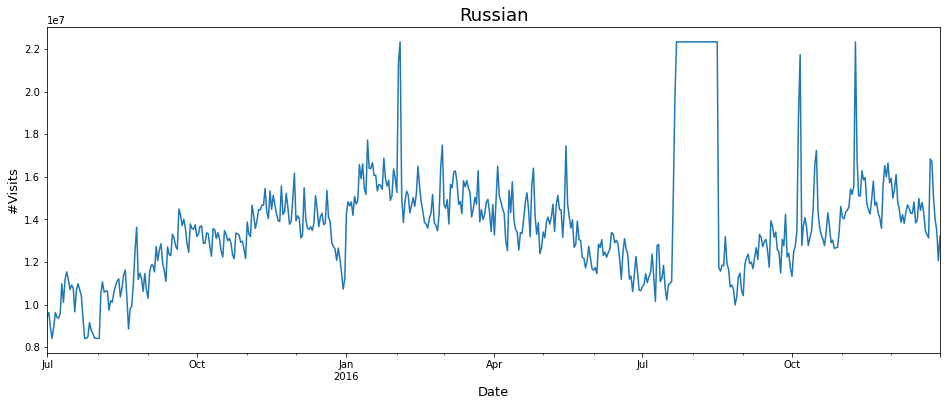

In [69]:
# Removing anomalies by clipping the top 5 percent and bottom 1 percent data.
plt.figure(figsize=(16,6))
_=russian.clip(lower=russian.quantile(0.01),upper=russian.quantile(0.95)).plot()
plt.title("Russian",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)

# Re-assigning the new dataset after clipping
russian=russian.clip(lower=russian.quantile(0.01),upper=russian.quantile(0.95))

### Decomposition of Time Series into different Components.

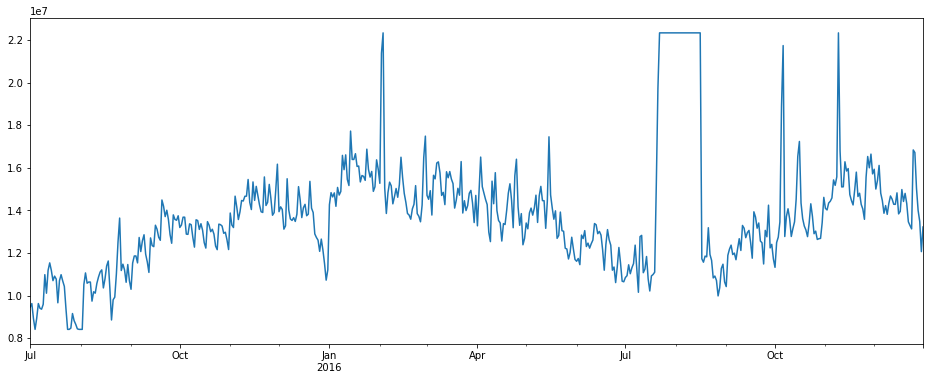

In [70]:
# Original Time Series Data
_=russian.plot()

model = sm.tsa.seasonal_decompose(russian,model='additive')

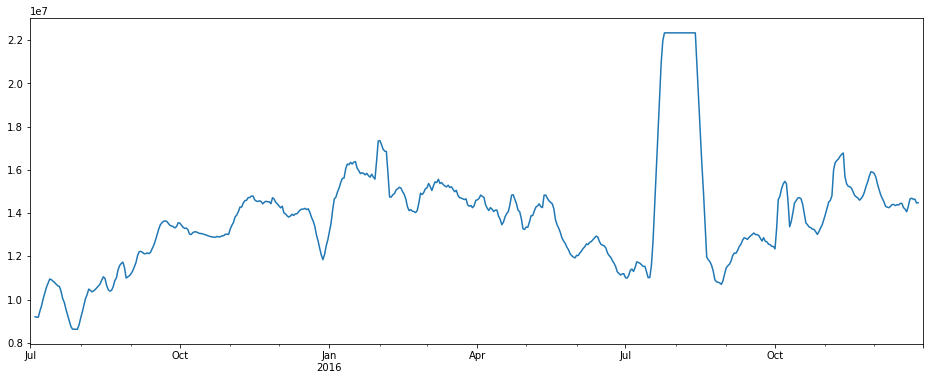

In [71]:
# Geeting the trend component of the time-series.
_=model.trend.plot(figsize=(16, 6))

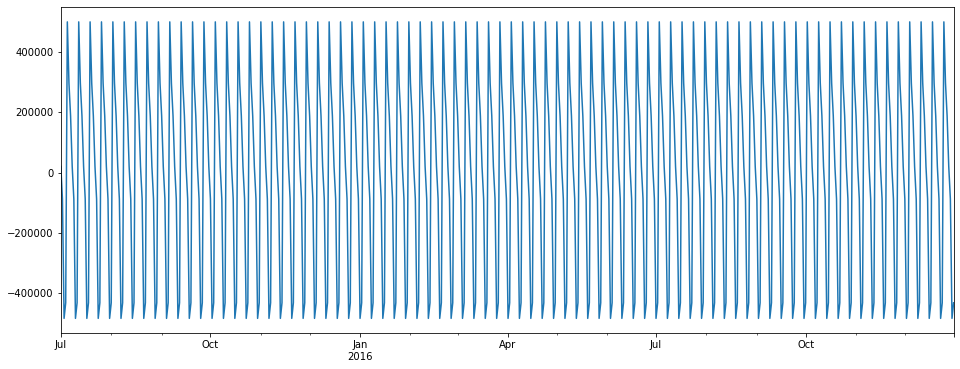

In [72]:
# Geeting the seasonal component of the time-series.
_=model.seasonal.plot(figsize=(16, 6))

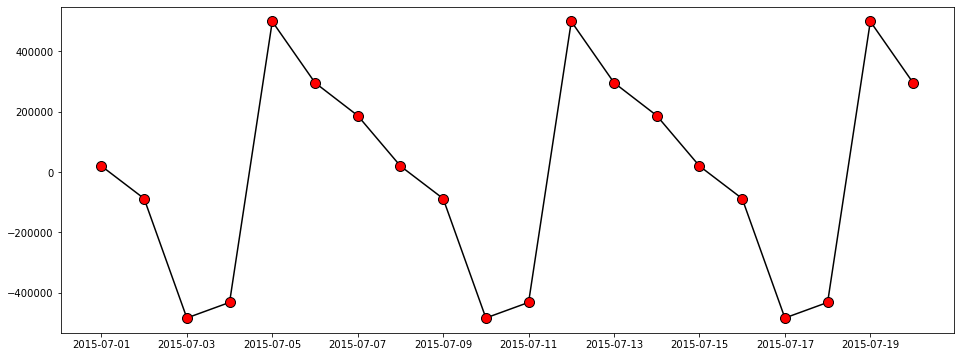

In [73]:
# Geeting the seasonal component of the time-series for a shorter time period.
_=plt.plot(model.seasonal[:20],color='black',marker='o',markerfacecolor='red',markersize=10)

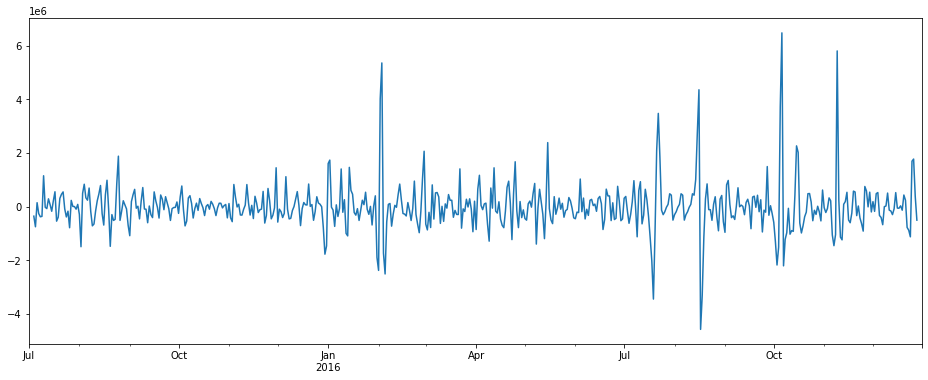

In [74]:
# Geeting the residual component of the time-series.
_=model.resid.plot(figsize=(16, 6))

Observation : 
* We can see an upward trend in the dataset.
* There is weekly seasonality in the data.
- The mean of the residuals is close to 0, but there are some big residuals at some places.

## 6) German

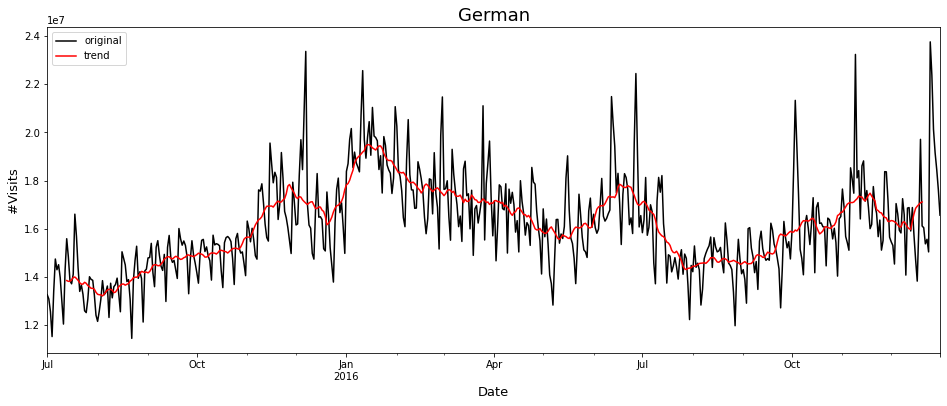

In [75]:
# PLotting the Time-Series.

plt.figure(figsize=(16,6))
german.plot(label='original',color='black')
german.rolling(24, center=True).mean().plot(label='trend',color='r')
plt.title("German",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)
plt.legend()
plt.show()

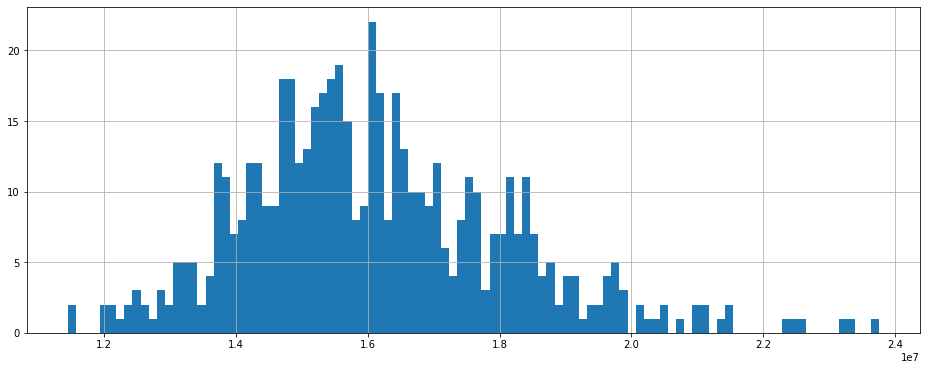

In [76]:
# Checking for anomalies.
plt.figure(figsize=(16,6))
_=german.hist(bins=100)

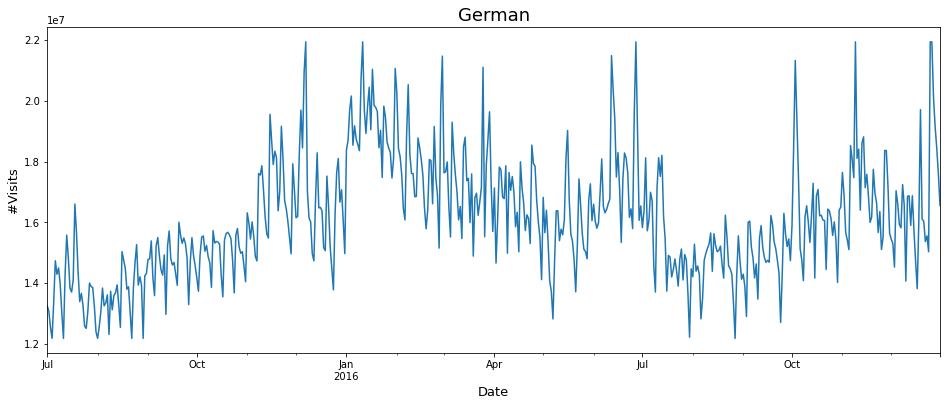

In [77]:
# Removing anomalies by clipping the top and bottom 1 percent data.
plt.figure(figsize=(16,6))
_=german.clip(lower=german.quantile(0.01),upper=german.quantile(0.99)).plot()
plt.title("German",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)

# Re-assigning the new dataset after clipping
german=german.clip(lower=german.quantile(0.01),upper=german.quantile(0.99))

### Decomposition of Time Series into different Components.

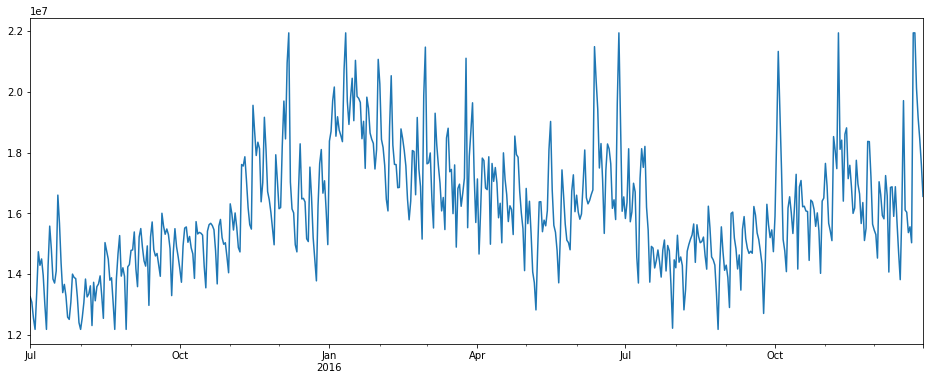

In [78]:
# Original Time Series Data
_=german.plot()

model = sm.tsa.seasonal_decompose(german,model='additive')

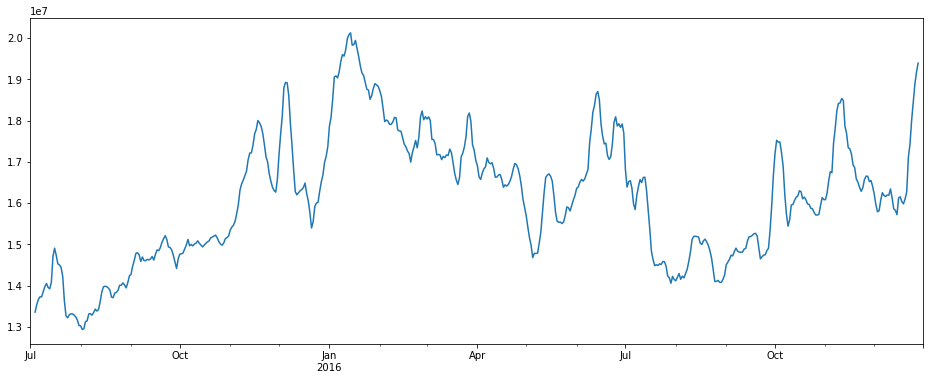

In [79]:
# Geeting the trend component of the time-series.
_=model.trend.plot(figsize=(16, 6))

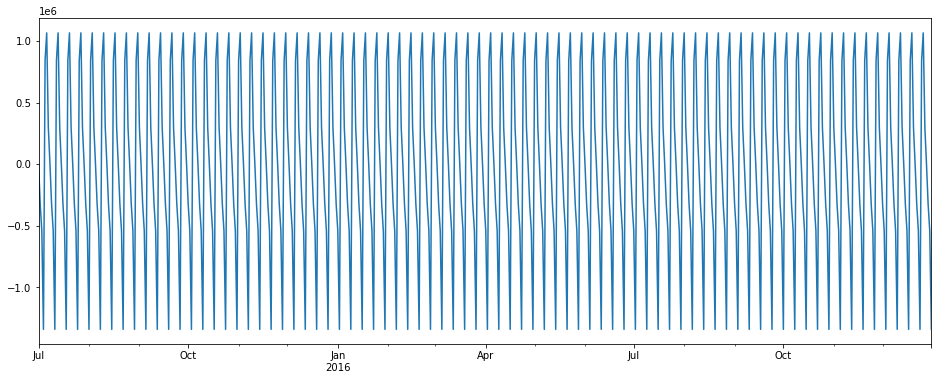

In [80]:
# Geeting the seasonal component of the time-series.
_=model.seasonal.plot(figsize=(16, 6))

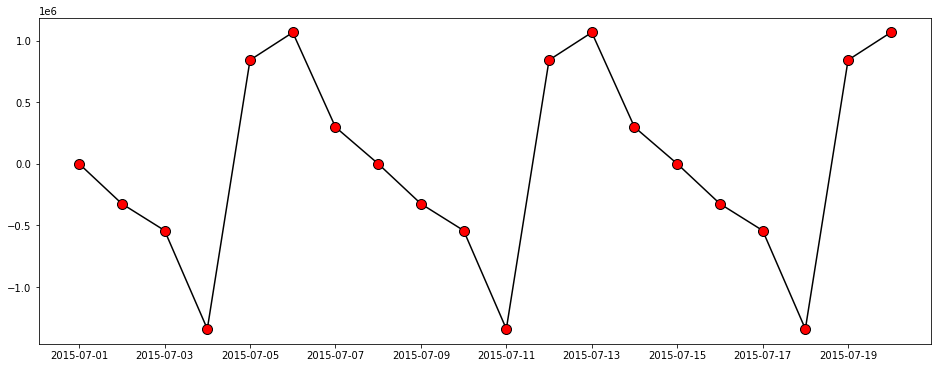

In [81]:
# Geeting the seasonal component of the time-series for a shorter time period.
_=plt.plot(model.seasonal[:20],color='black',marker='o',markerfacecolor='red',markersize=10)

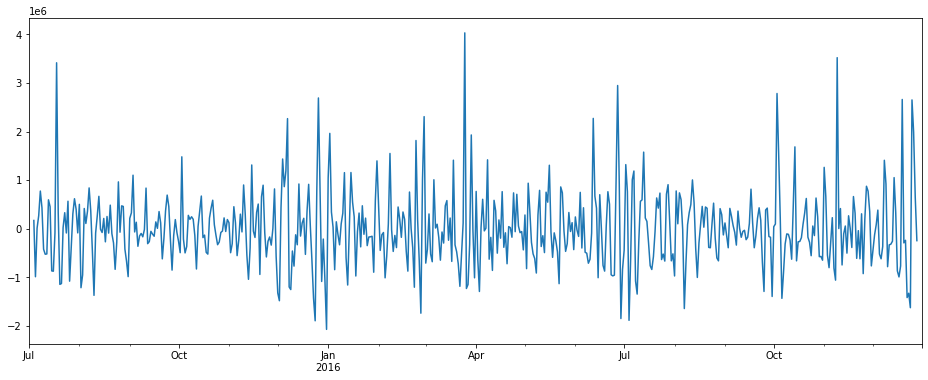

In [82]:
# Geeting the residual component of the time-series.
_=model.resid.plot(figsize=(16, 6))

Observation : 
* We can see an upward trend in the dataset.
* There is weekly seasonality in the data.
- The mean of the residuals is close to 0, but there are some big residuals at some places.

## 7) Japanese

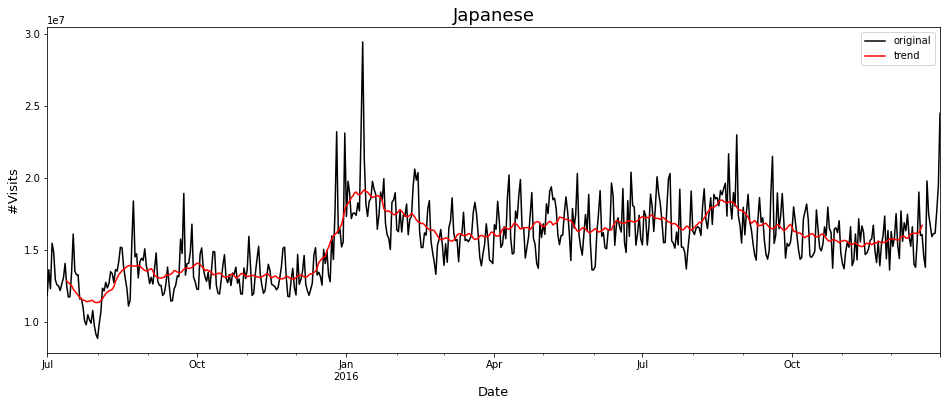

In [83]:
# PLotting the Time-Series.

plt.figure(figsize=(16,6))
japanese.plot(label='original',color='black')
japanese.rolling(24, center=True).mean().plot(label='trend',color='r')
plt.title("Japanese",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)
plt.legend()
plt.show()

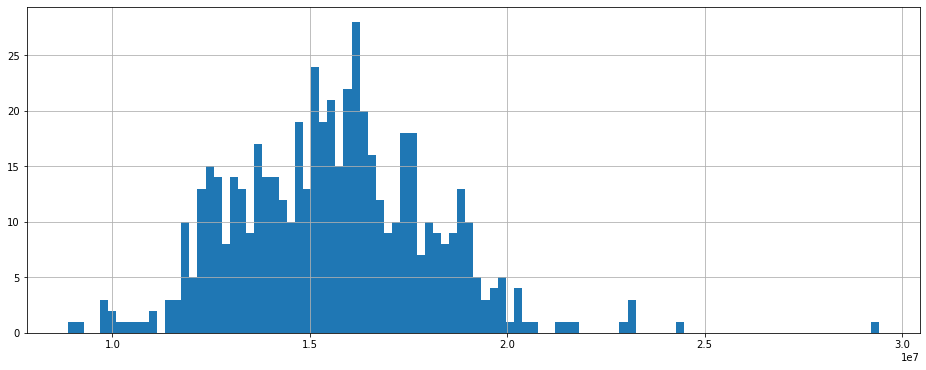

In [84]:
# Checking for anomalies.
plt.figure(figsize=(16,6))
_=japanese.hist(bins=100)

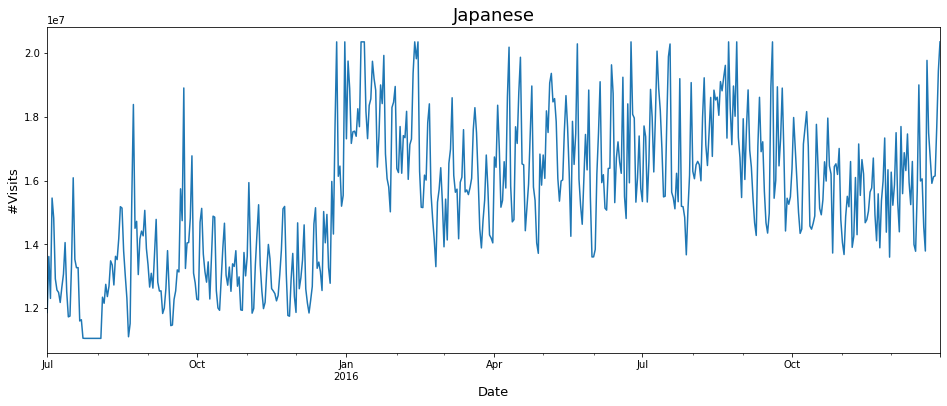

In [85]:
# Removing anomalies by clipping the top and bottom 2 percent data.
plt.figure(figsize=(16,6))
_=japanese.clip(lower=japanese.quantile(0.02),upper=japanese.quantile(0.98)).plot()
plt.title("Japanese",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)

japanese=japanese.clip(lower=japanese.quantile(0.02),upper=japanese.quantile(0.98))# Re-assigning the new dataset after clipping

### Decomposition of Time Series into different Components.

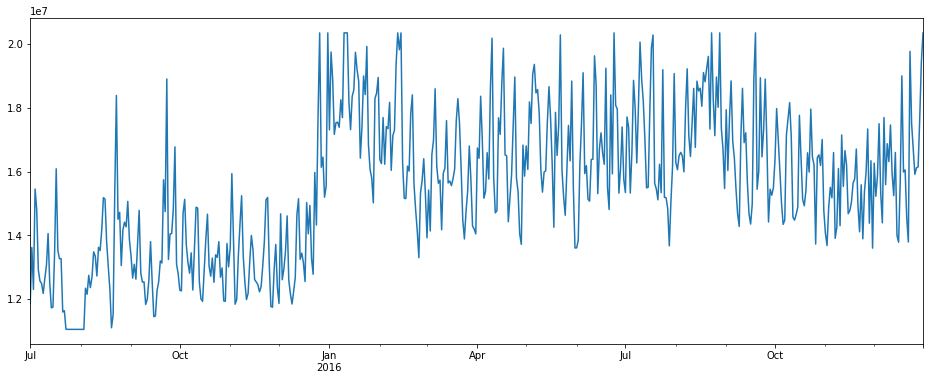

In [86]:
# Original Time Series Data
_=japanese.plot()

model = sm.tsa.seasonal_decompose(japanese,model='additive')

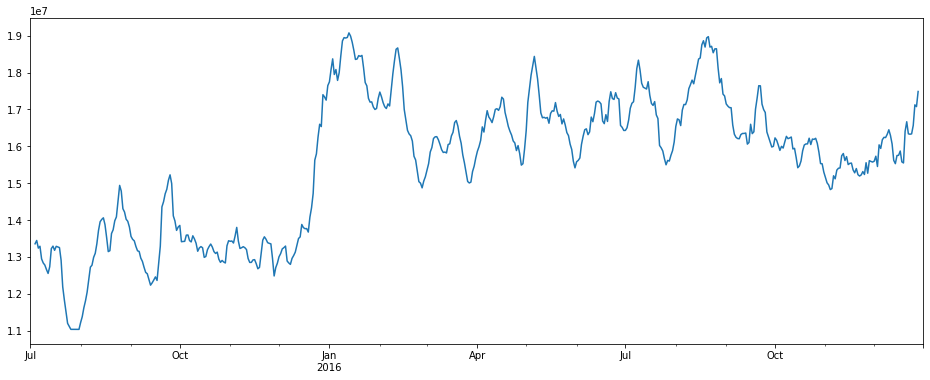

In [87]:
# Geeting the trend component of the time-series.
_=model.trend.plot(figsize=(16, 6))

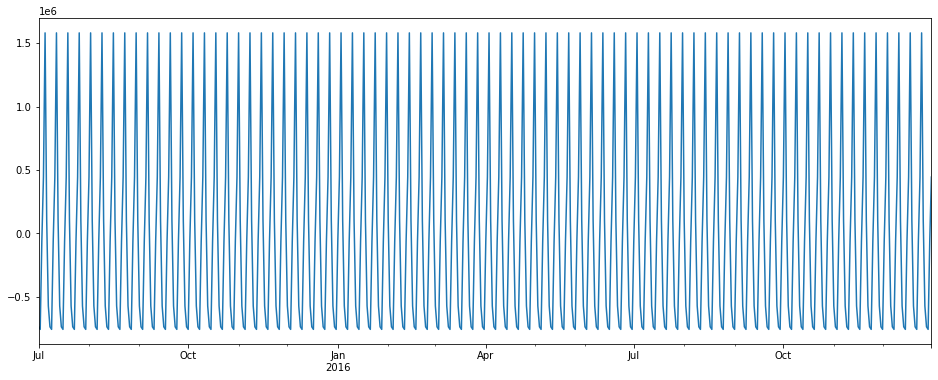

In [88]:
# Geeting the seasonal component of the time-series.
_=model.seasonal.plot(figsize=(16, 6))

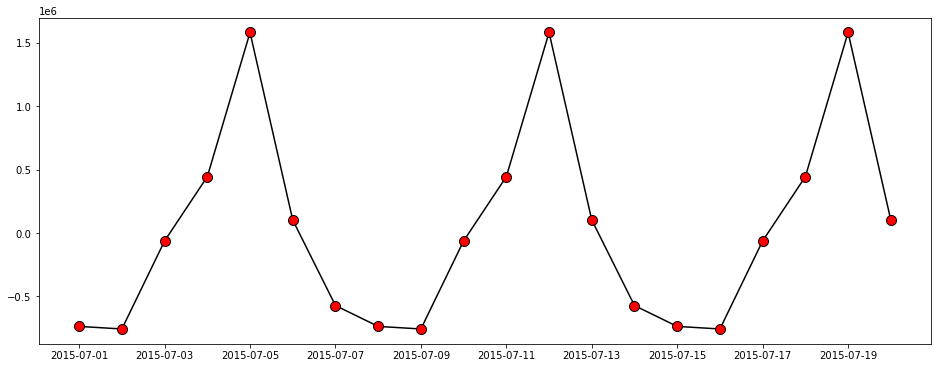

In [89]:
# Geeting the seasonal component of the time-series for a shorter time period.
_=plt.plot(model.seasonal[:20],color='black',marker='o',markerfacecolor='red',markersize=10)

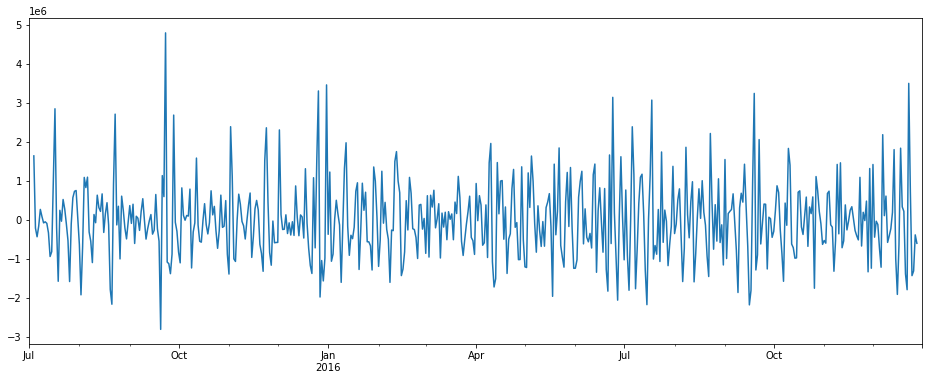

In [90]:
# Geeting the residual component of the time-series.
_=model.resid.plot(figsize=(16, 6))

Observation : 
* We can see an upward trend in the dataset.
* There is weekly seasonality in the data.
- The mean of the residuals is close to 0, but there are some big residuals at some places.

## 8) Spanish

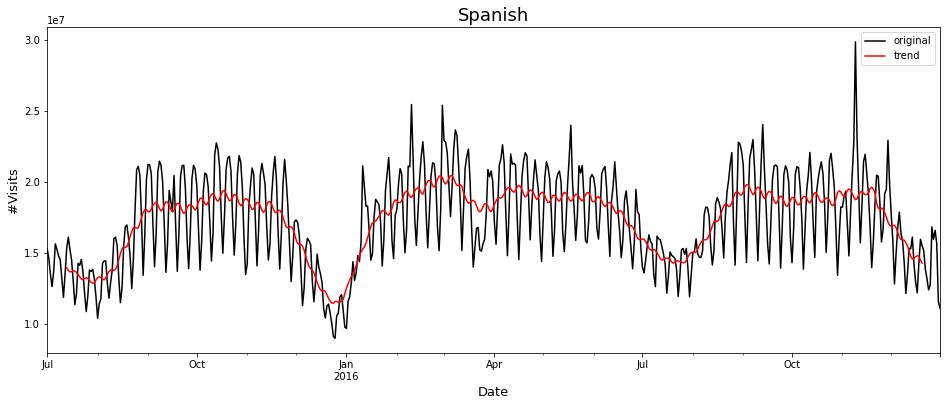

In [91]:
# PLotting the Time-Series.

plt.figure(figsize=(16,6))
spanish.plot(label='original',color='black')
spanish.rolling(24, center=True).mean().plot(label='trend',color='r')
plt.title("Spanish",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)
plt.legend()
plt.show()

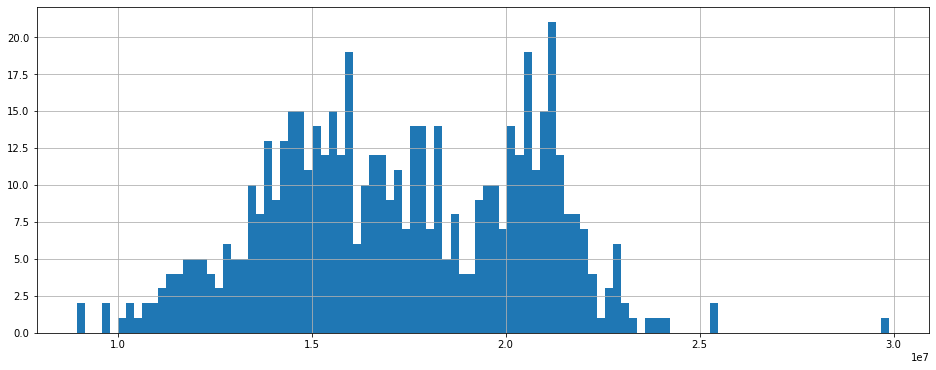

In [92]:
# Checking for anomalies.
plt.figure(figsize=(16,6))
_=spanish.hist(bins=100)

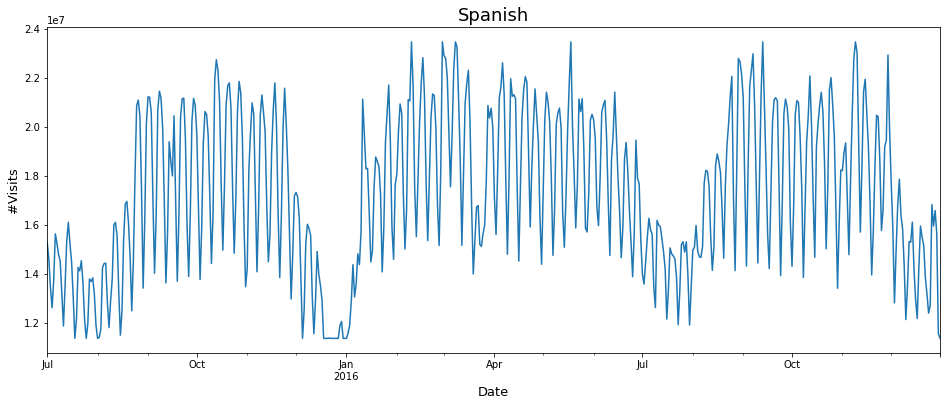

In [93]:
# Removing anomalies by clipping the top 1 percent and bottom 3 percent data.
plt.figure(figsize=(16,6))
_=spanish.clip(lower=spanish.quantile(0.03),upper=spanish.quantile(0.99)).plot()
plt.title("Spanish",fontsize=18)
plt.xlabel("Date",fontsize=13)
plt.ylabel("#Visits",fontsize=13)

# Re-assigning the new dataset after clipping
spanish=spanish.clip(lower=spanish.quantile(0.03),upper=spanish.quantile(0.99))

### Decomposition of Time Series into different Components.

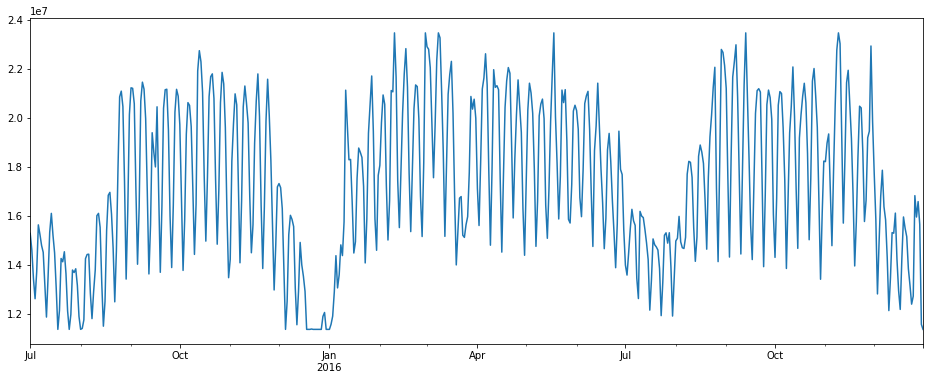

In [94]:
# Original Time Series Data
_=spanish.plot()

model = sm.tsa.seasonal_decompose(spanish,model='additive')

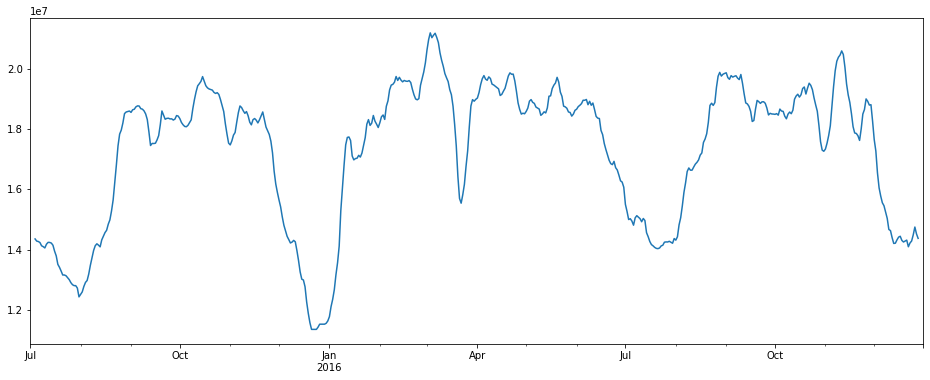

In [95]:
# Geeting the trend component of the time-series.
_=model.trend.plot(figsize=(16, 6))

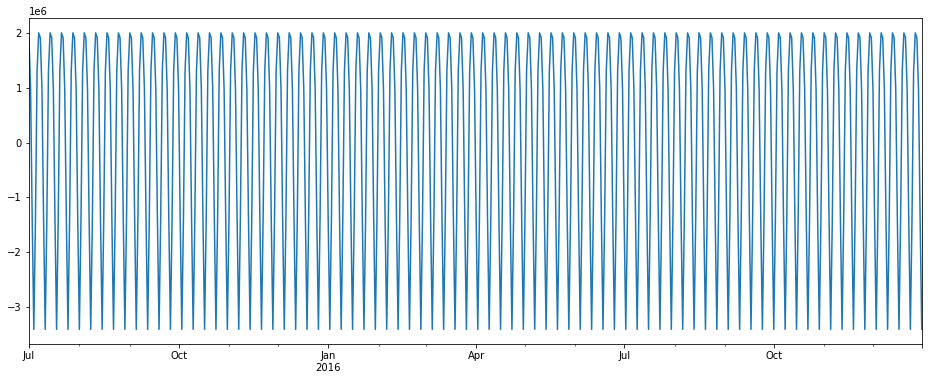

In [96]:
# Geeting the seasonal component of the time-series.
_=model.seasonal.plot(figsize=(16, 6))

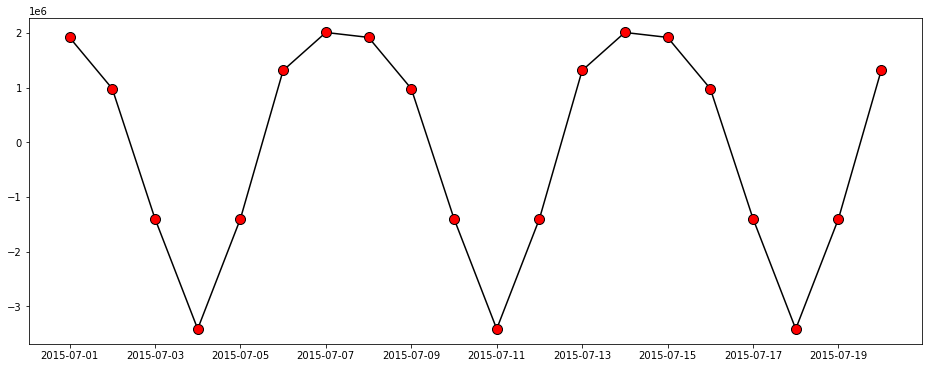

In [97]:
# Geeting the seasonal component of the time-series for a shorter time period.
_=plt.plot(model.seasonal[:20],color='black',marker='o',markerfacecolor='red',markersize=10)

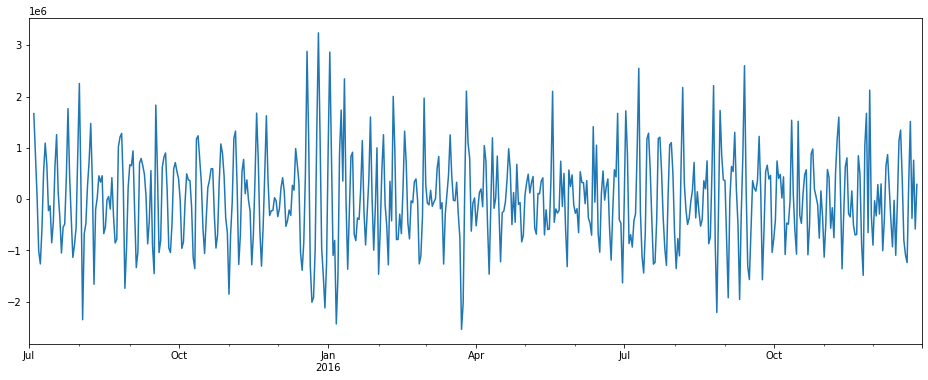

In [98]:
# Geeting the residual component of the time-series.
_=model.resid.plot(figsize=(16, 6))

Observation : 
* We can see an upward trend in the dataset.
* There is weekly seasonality in the data.
- The mean of the residuals is close to 0, but there are some big residuals at some places.
- There is cyclicity in the data, as the long-term patterns are repeating.

## Forecasting For English Time Series

### 1) Stationarity Check

In [127]:
# Augemented Dickey Fuller Test to validate whether the data is stationary.

def adf_test(dataset):
    pvalue = sm.tsa.stattools.adfuller(dataset)[1] 
    if pvalue <= 0.05:
      print('Sequence is stationary')
    else:
      print('Sequence is not stationary')

adf_test(english)

# The English time series is not stationary.

Sequence is not stationary


In [128]:
# Lets try to do differencing to make the data stationary. 
# We can use the ndiffs function from pmdarima library to find the optimal no of differecing required.

print('Number of Differecing Required:',ndiffs(english))

# Doing Augemented Dickey Fuller Test on the 1st Difference data to validate stationarity.
adf_test(english.diff(1).dropna())

Number of Differecing Required: 1
Sequence is stationary


### 2) PACF Plot

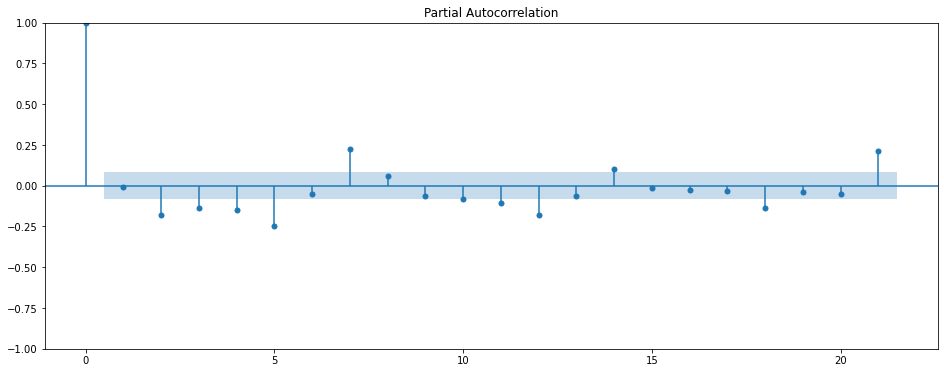

In [129]:
# From the PACF plot, we can find the number of lags which can be significant predictors to determine the order of AR.

plot_pacf(english.diff(1).dropna(),lags=21); 

#### Observation: 
- Lag 7 is significant.

### 3) ACF Plot

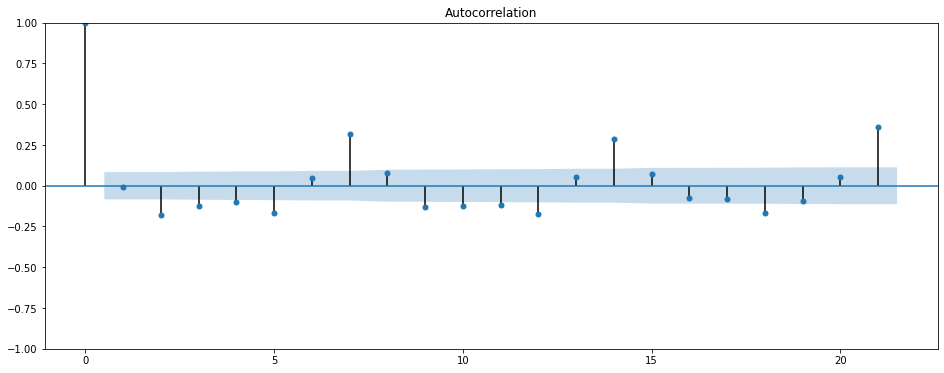

In [80]:
# From the PACF plot, we can find the number of lags which can be significant predictors to determine the order of MA.

plot_acf(english.diff().dropna(),lags=21); 

#### Observation: 
- Weekly lags such as 7,14 and 21 are significant.

## 4) Splitting Data

In [81]:
train = english.iloc[:-30]
test = english.iloc[-30:]

## 5) Defining Performance Measures

In [82]:
# Creating a function to print values of all these metrics.

def performance(actual, predicted):
    
    MAE=round(mae(actual, predicted), 3)
    RMSE=round(mse(actual, predicted)**0.5, 3)
    MAPE=round(mape(actual, predicted), 3)
    return MAE,RMSE,MAPE

## 6) Auto_Arima to find the best Parameters of the ARIMA model.

In [83]:
auto_arima_model=auto_arima(train)
display(auto_arima_model.summary())

# The best values of p,d and q were found to be 2,1 and 1.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  520
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -8919.686
Date:                Thu, 01 Dec 2022   AIC                          17847.371
Time:                        04:30:05   BIC                          17864.379
Sample:                    07-01-2015   HQIC                         17854.034
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6538      0.084      7.744      0.000       0.488       0.819
ar.L2         -0.1557      0.040     -3.901      0.000      -0.234      -0.077
ma.L1         -0.7211      0.086     -8.339      0.000      -0.891      -0.552
sigma2      5.055e+13    2.5e-16   2.02e+29      0.000    5.06e+13    5.06e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               842.60
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               3.14   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.08e+45. Standard errors may be unstable.
"""

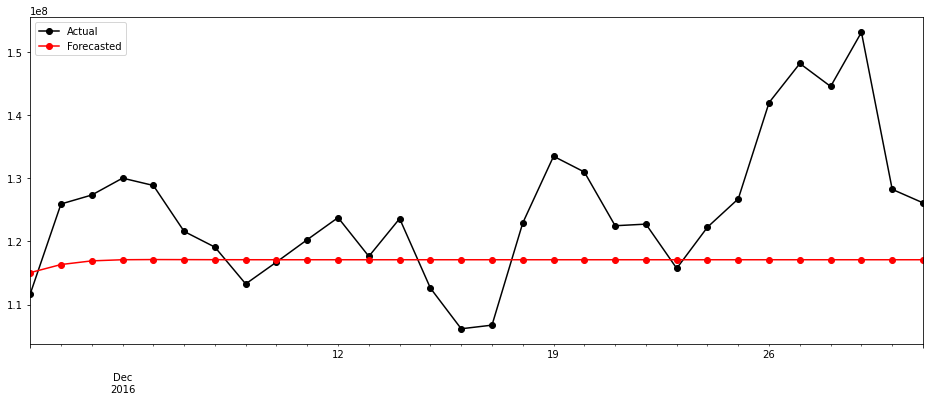

MAE : 10137133.123
RMSE : 13432216.201
MAPE: 0.077


In [84]:
# Using the values of 2,1,1 as p,d,q to foreacast 30 values.
pred = auto_arima_model.predict(30)

test.plot(style='-o',c='black',label='Actual')
pred.plot(style='-o',c='red',label='Forecasted')
plt.legend()
plt.show()

results=performance(test, pred)
print('MAE :',results[0])
print('RMSE :',results[1])
print('MAPE:',results[2])

# Observation - From the below plot and MAPE value, it look like this is not a good model.

## 7) Grid Search to find the best Parameters of the ARIMA model.

In [85]:
# Defining Grid Search to find the best parameters for ARIMA.

def manual_grid_arima(params_arr,train,test):
    p,d,q=list(range(1,params_arr[0]+1)),[params_arr[1]],list(range(1,params_arr[2]+1))
    order=[(x,y,z) for x in p for y in d for z in q]

    best_mape=float('inf')
    best_param=None
    
    for param in order:
        model = SARIMAX(train, order=param) 
        model = model.fit(disp=False)
        pred = model.forecast(steps=30)
        
        perf=mape(test, pred)
        if perf<best_mape:
            best_param=param
            best_mape=perf
            
    return best_param,best_mape

Best Parameters: (6, 1, 7)


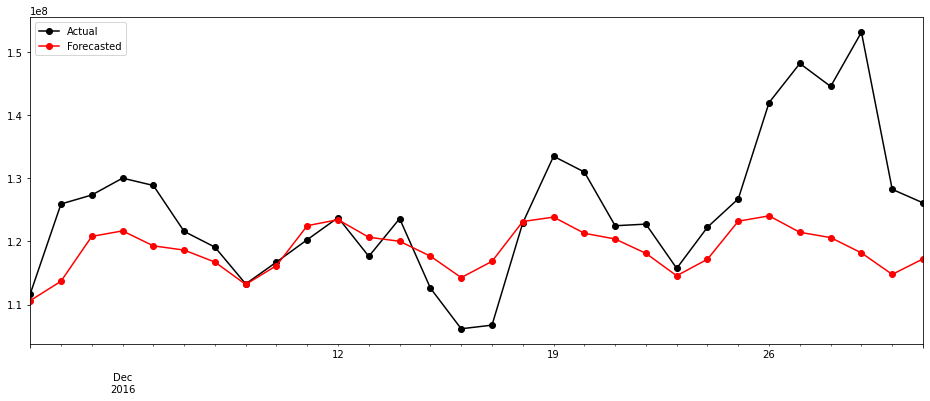

MAE : 7931877.328
RMSE : 11442387.36
MAPE: 0.06


In [86]:
# Getting the tuple of best parameters and building the best model.
# Range of p : [1,7], Range of d : [1,1], Range of q : [1,7]

best_params=manual_grid_arima([7,1,7],train,test)
print('Best Parameters:',best_params[0])

model = SARIMAX(train, order=best_params[0])
model = model.fit(disp=False)
pred = model.forecast(steps=30)

test.plot(style='-o',c='black',label='Actual')
pred.plot(style='-o',c='red',label='Forecasted')
plt.legend()
plt.show()

results=performance(test, pred)
print('MAE :',results[0])
print('RMSE :',results[1])
print('MAPE:',results[2])

# Observation - From the below plot and MAPE value, it look like this too isn't a very good model.

## 8) Grid Search to find the best Parameters of the SARIMA model.

In [87]:
# Defining Grid Search to find the best parameters for SARIMA.

def manual_grid_sarima(param1,param2,train,test):
    
    p,d,q=list(range(1,param1[0]+1)),[param1[1]],list(range(1,param1[2]+1))
    P,D,Q,S=list(range(1,param2[0]+1)),list(range(0,param1[1]+1)),list(range(1,param2[2]+1)),[param2[3]]
    order=[(x,y,z) for x in p for y in d for z in q]
    seasonal_order=[(w,x,y,z) for w in P for x in D for y in Q for z in S]
    
    best_mape=float('inf')
    best_param=None
    
    for p1 in order:
        for p2 in seasonal_order:
            model = SARIMAX(train, order=p1,seasonal_order=p2) 
            model = model.fit(disp=False)
            pred = model.forecast(steps=30)

            perf=mape(test, pred)
            if perf<best_mape:
                best_param=p1,p2
                best_mape=perf
            
    return best_param,best_mape

Best Parameters: (((2, 1, 2), (2, 0, 2, 7)), 0.05331143018032236)


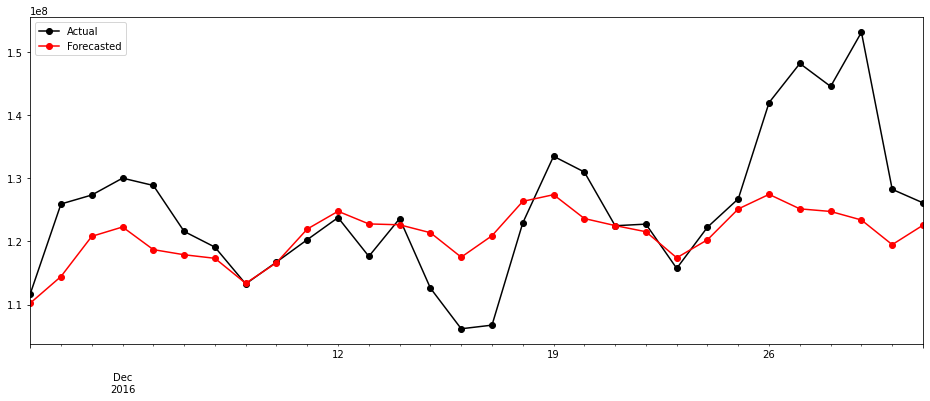

MAE : 6957326.382
RMSE : 10016875.219
MAPE: 0.053


In [90]:
# Getting the tuple of best parameters and building the best model.
# Range of p : [1,3], Range of p : [1,1], Range of q : [1,3]
# Range of P : [1,3], Range of D : [0,1], Range of Q : [1,3], Range of S : [7,7]

best_params=manual_grid_sarima([3,1,3],[3,1,3,7],train,test)
print('Best Parameters:',best_params)

model = SARIMAX(train, order=best_params[0][0],seasonal_order=best_params[0][1])
model = model.fit(disp=False)
pred = model.forecast(steps=30)

test.plot(style='-o',c='black',label='Actual')
pred.plot(style='-o',c='red',label='Forecasted')
plt.legend()
plt.show()

results=performance(test, pred)
print('MAE :',results[0])
print('RMSE :',results[1])
print('MAPE:',results[2])

# Observation - From the below plot and MAPE value, it look like this is a better model than the previous ones.

## 9) Grid Search to find the best Parameters of the SARIMAX model.

In [91]:
# The shareable link for Exog Dataset
link = 'https://drive.google.com/file/d/19qvuu7E8yD63o4WkOdy_lLFSrZlZPpuE/view?usp=share_link' 
id='19qvuu7E8yD63o4WkOdy_lLFSrZlZPpuE'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Exog_Campaign_eng.csv')  

# Importing the Exogeneous Variable Dataset Dataset.
exog=pd.read_csv('Exog_Campaign_eng.csv')['Exog']
exog.index=english.index
display(exog.head(5))

# Checking the shape of the dataset.
print('Shape:',exog.shape)

2015-07-01    0
2015-07-02    0
2015-07-03    0
2015-07-04    0
2015-07-05    0
Name: Exog, dtype: int64

Shape: (550,)


In [92]:
# Checking the percentage of value_counts.
display(np.round(exog.value_counts(normalize=True)*100,2))

# Checking for null values.
print('Null Values:',exog.isna().sum()) #There are no null values.

0    90.18
1     9.82
Name: Exog, dtype: float64

Null Values: 0


In [93]:
# Splitting "Exog" into train and test.
exog_train=exog[:-30]
exog_test=exog[-30:]

In [94]:
# Defining Grid Search to find the best parameters for SARIMAX.

def manual_grid_sarimax(param1,param2,train,test,exog_train,exog_test):
    
    p,d,q=list(range(1,param1[0]+1)),[param1[1]],list(range(1,param1[2]+1))
    P,D,Q,S=list(range(1,param2[0]+1)),list(range(0,param1[1]+1)),list(range(1,param2[2]+1)),[param2[3]]
    order=[(x,y,z) for x in p for y in d for z in q]
    seasonal_order=[(w,x,y,z) for w in P for x in D for y in Q for z in S]
    
    start,end=len(train),len(train)+len(test)-1
    best_mape=float('inf')
    best_param=None
    
    for p1 in order:
        for p2 in seasonal_order:
            model = SARIMAX(endog=train,exog=exog_train,order=p1,seasonal_order=p2,enforce_invertibility=False)
            model = model.fit()
            pred = model.predict(start=start, end=end, exog=exog_test)
            
            perf=mape(test, pred)
            if perf<best_mape:
                best_param=p1,p2
                best_mape=perf
            
    return best_param,best_mape

Best Parameters: (((2, 1, 3), (3, 1, 1, 7)), 0.03660649925812153)


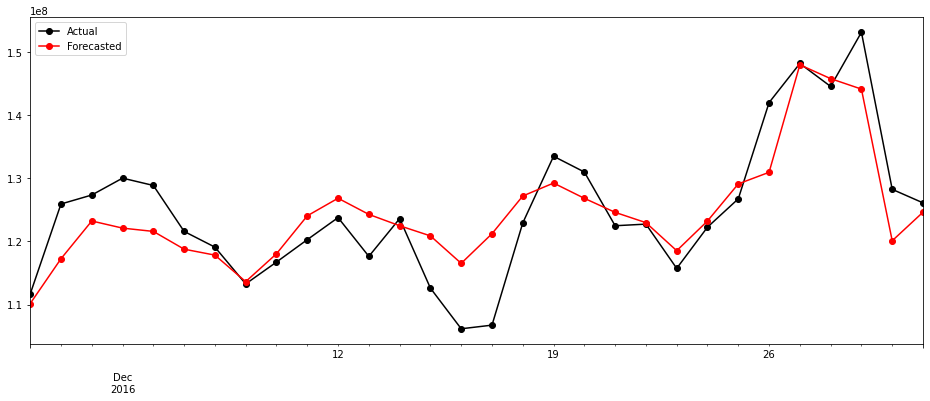

MAE : 4505253.462
RMSE : 5830798.679
MAPE: 0.037


In [95]:
# Getting the tuple of best parameters and building the best model.
# Range of p : [1,3], Range of p : [1,1], Range of q : [1,3]
# Range of P : [1,3], Range of D : [0,1], Range of Q : [1,3], Range of S : [7,7]

best_params=manual_grid_sarimax([3,1,3],[3,1,3,7],train,test,exog_train,exog_test)
print('Best Parameters:',best_params)

model = SARIMAX(endog=train,exog=exog_train,order=best_params[0][0],seasonal_order=best_params[0][1],
                enforce_invertibility=False)
model = model.fit()
start,end=len(train),len(train)+len(test)-1
pred = model.predict(start=start, end=end, exog=exog_test)

test.plot(style='-o',c='black',label='Actual')
pred.plot(style='-o',c='red',label='Forecasted')
plt.legend()
plt.show()

results=performance(test, pred)
print('MAE :',results[0])
print('RMSE :',results[1])
print('MAPE:',results[2])

# Observation - From the below plot and MAPE value, this is the best model that we have found till now.

## 9) Grid Search to find the best Parameters of the Triple Exponential Smoothing model.

In [96]:
# Defining Function for Triple Exponential Smoothing

def manual_grid_tes(train,test):
    values=np.linspace(start=0.1,stop=0.9,num=9)
    best_mape=float('inf')
    best_param=None

    for value in values:
        for kind in [('additive','additive'),('multiplicative','additive'),('additive','multiplicative'),('multiplicative','multiplicative')]:
            model = sm.tsa.ExponentialSmoothing(train, trend=kind[0], seasonal=kind[1]).fit(smoothing_level=value)
            pred = model.forecast(steps=30)
            perf=mape(pred,test)
            if perf<best_mape:
                best_param=kind[0],kind[1],value
                best_mape=perf
                
    return best_param,best_mape

Best Parameters:
Trend : additive
Seasonality : additive
Alpha : 0.1


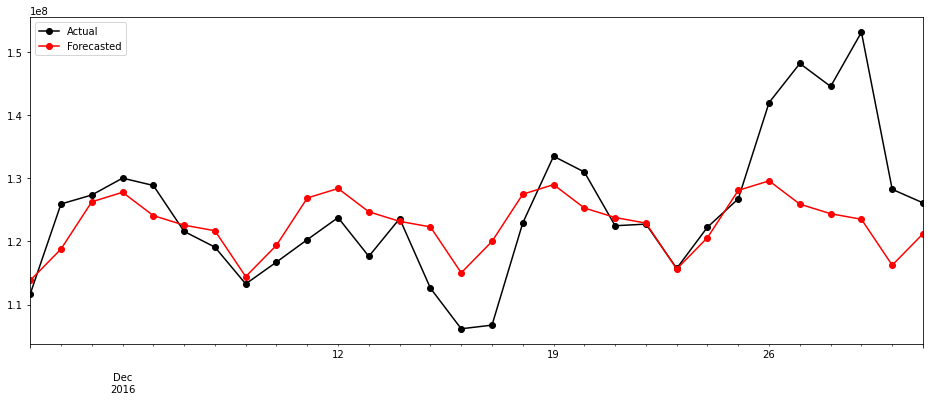

MAE : 6527734.969
RMSE : 9558978.136
MAPE: 0.05


In [97]:
# Comparing additive/multiplicative Trend with additive/multiplicative Seasonality.

best_params=manual_grid_tes(train,test)
print('Best Parameters:')
print('Trend :',best_params[0][0])
print('Seasonality :',best_params[0][1])
print('Alpha :',best_params[0][2])

model=sm.tsa.ExponentialSmoothing(train, trend=best_params[0][0], seasonal=best_params[0][1]).fit(smoothing_level=best_params[0][2])
pred = model.forecast(steps=30)
test.plot(style='-o',c='black',label='Actual')
pred.plot(style='-o',c='red',label='Forecasted')
plt.legend()
plt.show()

results=performance(test, pred)
print('MAE :',results[0])
print('RMSE :',results[1])
print('MAPE:',results[2])
 
# Observation - From the below plot and MAPE value, this is a good model, but not the best.

## Prophet

- For using Prophet, data set should contain only two columns with column names as ‘ds’ and ‘y’
- ‘ds’ should always be in ‘date-time’ format.

In [98]:
def prophet_forecast(language):

  language=language.reset_index()
  language.columns=['ds','y']
  model = Prophet(weekly_seasonality=True)
  model.fit(language[:-30]) #here we are leaving last 30 observations because we will predict it in 'future'
  pred = model.predict(language)
  pred=pred.set_index('ds')

  results=performance(language['y'][-30:], pred['yhat'][-30:])
  
  return results,pred['yhat'][-30:]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


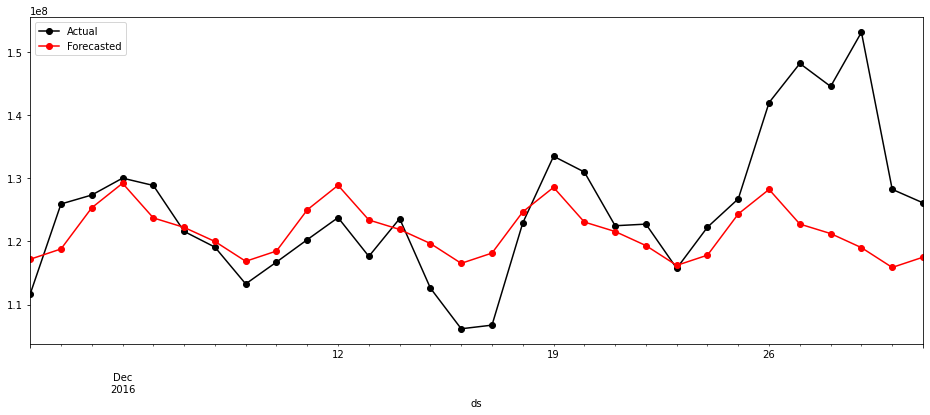

MAE : 7241692.003
RMSE : 10636852.373
MAPE: 0.055


In [99]:
results,pred = prophet_forecast(english)

english[-30:].plot(style='-o',c='black',label='Actual')
pred.plot(style='-o',c='red',label='Forecasted')
plt.legend()
plt.show()

print('MAE :',results[0])
print('RMSE :',results[1])
print('MAPE:',results[2])

# Observation - From the below plot and MAPE value, this is a good model, but not the best.

## Creating a Pipeline

In [100]:
# To get the best models for other language time series, we can create a pipeline/function.
# We can get the performance measures and best models using 4 techniques - ARIMA, SARIMA, Prophet and TES.

def get_best_models(language):
    train=language[:-30]
    test=language[-30:]
    arima=manual_grid_arima([7,1,7],train,test)[1]
    sarima=manual_grid_sarima([3,1,3],[3,1,3,7],train,test)[1]
    tes=manual_grid_tes(train,test)[1]
    prophet=prophet_forecast(language)[0][2]
    return [arima,sarima,tes,prophet]

In [101]:
# Getting the MAPE results of each model for each of the language time series, and creating a dataframe.
results=[]
for language in [chinese,french,english,indonesian,russian,german,japanese,spanish]:
    results.append(get_best_models(language))
  
results_df=pd.DataFrame(data=results,columns=['ARIMA','SARIMA','TES','Prophet'],
             index=["Chinese","French","English","Indonesian","Russian","German","Japanese","Spanish"])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [102]:
# Final MAPE Results of the different language Time-Series.
results_df

ARIMA    SARIMA       TES  Prophet
Chinese     0.031569  0.030852  0.031552    0.064
French      0.073203  0.066770  0.071066    0.063
English     0.059848  0.053311  0.053013    0.055
Indonesian  0.163876  0.130348  0.154988    0.319
Russian     0.086872  0.092336  0.091440    0.041
German      0.065745  0.064366  0.067884    0.079
Japanese    0.071681  0.067238  0.075501    0.076
Spanish     0.209937  0.119015  0.125618    0.297

## Insights and Recommendations
- 1) From the results dataframe, we get the follwing count of being the best model:
    * ARIMA: 0
    * SARIMA: 5 
    * TES: 1
    * Prophet: 2
- 2) My understanding is that because the data had seasonality and ARIMA models do not account for seasonality, hene they performed poorly all the time.
- 3) SARIMA gave the best result 5 out of 8 times. We can therefore choose this model for out forecasting. However the time required to hyperparamter tune was very high and thus we need to decide keeping this limitation in mind.
- 4) If time complexity is a big challenge, then we can go for TES model. Even though Prophet emerged the winner 2 out of 8 times, but I would still choose TES to be the 2nd best model. If we closely see the results dataframe, we can observe that TES performed almost as good as SARIMA and at a very small time complexity. Even though Prophet emerged victorious a couple of times, however its performance in the some of the other language time series were very bad. Hence we cannot totally be assured with Prophet.
- 5) From SARIMAX model results and forecast, we observed that the addition of Exogeneous variables can significantly improve the accuracy of the forecasts.